# Predicting Credit Card Default
**Group F**: Nicolas Ford, To Eun Kim, Zi Lian Lim, Xiaoqi Tan, Chi Xue, Jingting Yan
<br>
January 15, 2021

# **1. Introduction**

This notebook aims to explore and experiment a range of different machine learning techniques to identify a stronger predictive model when classifying potential defaulting accounts utilizing the UCI 'Default of Credit Card Clients' dataset. We decided to choose three main categories of methodologies to attempt: Decision Trees (**AdaBoost**, **XGBoost** and **Gradient Boosting**), **Random Forest** and **Artificial Neural Networks**. After comparing their performances, we chose (non-oversampled) XGBoost as our final methodology.

#### Statistics of the optimal model:
1. **Accuracy score**: 0.790
2. **f1 score**: 0.532
3. **ROC AUC**: 0.708
4. **False Positive**: 708 cases, **False Negative**: 551 cases.
5. Top 3 features appeared the most in a tree: PAY_AMT1, BILL_AMT1, PAY_AMT5. The feature has the highest average gain and coverage of splits is PAY_1. 
<br>Top 3 features appeared the least in a tree: PAY_5, PAY_3, PAY_4. The feature has the lowest average gain and coverage of splits is AgeBin.

#### Feature selection results:
- Selected features for **n = 3**: 'PAY_1', 'PAY_2', 'PAY_3'
- Selected features for **n = 5**: 'PAY_1', 'PAY_2', 'PAY_3', 'PAY_5', 'PAY_4'
- **Conclusion**: The history of past payment (PAY_n) are of the most importance.

# **2. Data Import** 

### 2.1 Library Imports

Install packages in conda environments.

In [14]:
conda install -c anaconda scikit-learn

Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


Note that in this notebook, the **0.5.0** version of imblearn is required:

In [15]:
conda install -c conda-forge imbalanced-learn==0.5.0

\ 
Note: you may need to restart the kernel to use updated packages.


In [ ]:
conda install -c conda-forge tensorflow

In [ ]:
conda install -c conda-forge keras

In [ ]:
conda install -c conda-forge xgboost

In [1]:
import warnings
warnings.filterwarnings('ignore')

import io
import time

import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import ensemble
from sklearn.datasets import make_classification
from sklearn.preprocessing import MinMaxScaler, Normalizer, StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier

from numpy import where
from imblearn.over_sampling import SMOTE, BorderlineSMOTE
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.optimizers import RMSprop, Adam
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Dropout, Flatten, Dense

import xgboost as xgb
from xgboost import XGBClassifier

Using TensorFlow backend.


### 2.2 Load datasets
Simply modify the data path to load your data.

In [2]:
# Data paths setting
path = 'data/' # change to your local file location
train_data_path = path + 'CreditCard_train.csv'
test_data_path = path + 'CreditCard_test.csv'  

In [3]:
# pass the second line in the CSV file as column names
df_train = pd.read_csv(train_data_path, header=1)
df_test = pd.read_csv(test_data_path, header=1)

In [4]:
df_train.rename(columns={'PAY_0':'PAY_1'}, inplace=True) # change strange (inconsistent) column name 'PAY_0'
df_train.rename(columns={'default payment next month':'default'}, inplace=True) # shorten the name of the target column
df_train

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23995,23996,80000,1,2,1,25,1,2,2,0,...,80215,63296,49854,3800,6,3636,2646,2000,1830,0
23996,23997,20000,1,2,1,25,0,0,0,0,...,17322,17119,17350,1552,2659,1419,606,500,1000,0
23997,23998,10000,1,2,2,26,0,0,0,0,...,17506,16608,9176,1300,2200,1300,320,1820,1000,0
23998,23999,20000,1,5,2,26,0,0,0,0,...,39950,0,0,3055,1467,1096,1000,0,0,0


In [5]:
# check the ratio of train-test split
print('train:', df_train.shape[0] / (df_train.shape[0] + df_test.shape[0]))
print('test:', df_test.shape[0] / (df_train.shape[0] + df_test.shape[0]))

train: 0.8
test: 0.2


Train-test-split is 8:2.

# **3. Data Exploration and Transformation**
This section contains four parts: 1) Data Exploration; 2) Data Cleaning; 3) Exploratory Data Analysis; 4) Feature Engineering.

### 3.1 Data Exploration
1. Check missing values.
2. Check if labels in categorical variables are all documented.
3. Check if outliers existed in numerical variables: a) negative values; b) extreme values.
4. Investigate whether the training set is balanced (ratio of 'default').

**3.1.1 Check missing values**

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24000 entries, 0 to 23999
Data columns (total 25 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   ID         24000 non-null  int64
 1   LIMIT_BAL  24000 non-null  int64
 2   SEX        24000 non-null  int64
 3   EDUCATION  24000 non-null  int64
 4   MARRIAGE   24000 non-null  int64
 5   AGE        24000 non-null  int64
 6   PAY_1      24000 non-null  int64
 7   PAY_2      24000 non-null  int64
 8   PAY_3      24000 non-null  int64
 9   PAY_4      24000 non-null  int64
 10  PAY_5      24000 non-null  int64
 11  PAY_6      24000 non-null  int64
 12  BILL_AMT1  24000 non-null  int64
 13  BILL_AMT2  24000 non-null  int64
 14  BILL_AMT3  24000 non-null  int64
 15  BILL_AMT4  24000 non-null  int64
 16  BILL_AMT5  24000 non-null  int64
 17  BILL_AMT6  24000 non-null  int64
 18  PAY_AMT1   24000 non-null  int64
 19  PAY_AMT2   24000 non-null  int64
 20  PAY_AMT3   24000 non-null  int64
 21  PAY_AMT4   2

No Missing Values. All variables have numerical values (int64).

**3.1.2 Check undocumented labels**

In [7]:
# check if the values of categorical variable in training set are well-documented
print('SEX:', sorted(df_train['SEX'].unique()))
print('EDUCATION:', sorted(df_train['EDUCATION'].unique()))
print('MARRIAGE:', sorted(df_train['MARRIAGE'].unique()))
print('PAY_1:', sorted(df_train['PAY_1'].unique()))
print('PAY_2:', sorted(df_train['PAY_2'].unique()))
print('PAY_3:', sorted(df_train['PAY_3'].unique()))
print('PAY_4:', sorted(df_train['PAY_4'].unique()))
print('PAY_5:', sorted(df_train['PAY_5'].unique()))
print('PAY_6:', sorted(df_train['PAY_6'].unique()))
print('default:', sorted(df_train['default'].unique()))

SEX: [1, 2]
EDUCATION: [0, 1, 2, 3, 4, 5, 6]
MARRIAGE: [0, 1, 2, 3]
PAY_1: [-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8]
PAY_2: [-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8]
PAY_3: [-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8]
PAY_4: [-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8]
PAY_5: [-2, -1, 0, 2, 3, 4, 5, 6, 7, 8]
PAY_6: [-2, -1, 0, 2, 3, 4, 5, 6, 7, 8]
default: [0, 1]


Undocumented categories existed in the training set:
- EDUCATION: 0, 5, 6  
- MARRIAGE: 0  
- PAY_1 to PAY_6: -2, 0

In [8]:
# Count the number of rows for each undocumented label
undocumented_labels = ['EDUCATION == 0','EDUCATION == 5','EDUCATION == 6','MARRIAGE == 0','PAY_n == -2', 'PAY_n == 0']
counts = pd.DataFrame(index=undocumented_labels, columns=['Training'])

# EDUCATION, training set
counts.loc['EDUCATION == 0', 'Training'] = df_train[df_train['EDUCATION'] == 0].shape[0]
counts.loc['EDUCATION == 5', 'Training'] = df_train[df_train['EDUCATION'] == 5].shape[0]
counts.loc['EDUCATION == 6', 'Training'] = df_train[df_train['EDUCATION'] == 6].shape[0]

# MARRIAGE, training set
counts.loc['MARRIAGE == 0', 'Training'] = df_train[df_train['MARRIAGE'] == 0].shape[0]

# PAY_1 to PAY_6, training set
counts.loc['PAY_n == -2', 'Training'] = df_train[(df_train['PAY_1'] == -2) | (df_train['PAY_2'] == -2) | 
                                                 (df_train['PAY_3'] == -2) | (df_train['PAY_4'] == -2) | 
                                                 (df_train['PAY_5'] == -2) | (df_train['PAY_6'] == -2)].shape[0]
counts.loc['PAY_n == 0', 'Training'] = df_train[(df_train['PAY_1'] == 0) | (df_train['PAY_2'] == 0) | 
                                                (df_train['PAY_3'] == 0) | (df_train['PAY_4'] == 0) | 
                                                (df_train['PAY_5'] == 0) | (df_train['PAY_6'] == 0)].shape[0]

counts

,Training
EDUCATION == 0,11
EDUCATION == 5,207
EDUCATION == 6,37
MARRIAGE == 0,41
PAY_n == -2,5185
PAY_n == 0,16929


**Solution:** *(will be dealt in the **Data Cleaning** phase)*
- EDUCATION: categorise 0, 5, 6 as 4 (*others*)  
*others* may refer to education level either higher than graduate school or lower than high school.  
- MARRIAGE: categorise 0 as 3 (*others*)  
- PAY_1 to PAY_6: keep -2 and categorise 0 as -1 (*pay duly*)

**3.1.3 Check outliers in numerical variables**

**Check negative values**

In [9]:
numerical_features = ['LIMIT_BAL', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 
                      'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
# numerical features description
df_train[numerical_features].describe()

,LIMIT_BAL,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
count,24000.000000,24000.000000,24000.000000,2.400000e+04,24000.000000,24000.000000,24000.000000,24000.000000,2.400000e+04,24000.00000,24000.000000,24000.000000,24000.000000
mean,165495.986667,50596.884708,48646.064125,4.636706e+04,42368.188417,40000.682542,38563.710625,5542.912917,5.815336e+03,4969.26600,4743.480042,4783.486042,5189.399042
std,129128.744855,72649.374256,70364.600436,6.819390e+04,63070.680934,60345.012766,59155.759799,15068.576072,2.079703e+04,16095.61434,14883.269990,15270.405279,17630.371990
min,10000.000000,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000
25%,50000.000000,3631.500000,3098.500000,2.773500e+03,2340.000000,1740.000000,1234.750000,1000.000000,8.000000e+02,379.00000,279.750000,244.000000,60.750000
50%,140000.000000,22330.000000,21339.000000,2.003900e+04,18940.500000,18107.500000,17036.000000,2100.000000,2.000000e+03,1702.50000,1500.000000,1500.000000,1500.000000
75%,240000.000000,65779.500000,62761.250000,5.929800e+04,52188.500000,49746.500000,48796.250000,5000.000000,5.000000e+03,4347.25000,4000.000000,4005.000000,4000.000000
max,1000000.000000,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,505000.000000,1.684259e+06,896040.00000,497000.000000,417990.000000,528666.000000


In [10]:
print('Negative BILL_AMT in training set:', df_train[(df_train['BILL_AMT1'] < 0) | (df_train['BILL_AMT2'] < 0) |
                                                     (df_train['BILL_AMT3'] < 0) | (df_train['BILL_AMT4'] < 0) |
                                                     (df_train['BILL_AMT5'] < 0) | (df_train['BILL_AMT6'] < 0)].shape[0])

Negative BILL_AMT in training set: 1496


There are negative values for bill statement in training set (1496 rows).
We are not going to convert negatives to zero.

**Check extremely large or small values**
<br><br>
LIMIT_BAL, BILL_AMT and PAY_AMT all have a very broad range. Need to check if these are outliers.
<br>
**Method:** Check if the amount of previous payment (PAY_AMT) & bill statement (BILL_AMT) lie within the 'sensible' range of given credit (LIMIT_BAL). Choose LIMIT_BAL values below 5th percentile or above 95th percentile to check.

In [11]:
# investigate the percentiles for LIMIT_BAL, PAY_AMT and BILL_AMT
percentiles = []
for var in numerical_features:
    percentiles.append(list(np.percentile(df_train[var], i) for i in range(5,100,10)))

pd.DataFrame(data=percentiles, index=numerical_features, columns=['5th','15th','25th','35th','45th','55th','65th','75th','85th','95th'])

,5th,15th,25th,35th,45th,55th,65th,75th,85th,95th
LIMIT_BAL,20000.0,50000.00,50000.00,80000.00,120000.00,150000.00,200000.00,240000.00,300000.00,430000.00
BILL_AMT1,0.0,815.00,3631.50,9245.90,17706.20,28347.00,46009.85,65779.50,105939.05,197600.00
BILL_AMT2,0.0,495.00,3098.50,8760.30,17385.00,27619.45,43981.00,62761.25,101462.40,191542.10
BILL_AMT3,0.0,390.00,2773.50,8600.55,16985.55,26011.90,40181.05,59298.00,97224.80,184792.90
BILL_AMT4,0.0,370.85,2340.00,7851.95,15528.55,22497.40,33408.05,52188.50,89414.40,171381.90
BILL_AMT5,0.0,225.00,1740.00,6805.65,14111.55,20328.45,30177.00,49746.50,84116.30,164724.15
BILL_AMT6,0.0,0.00,1234.75,5369.65,12266.40,19826.00,29736.40,48796.25,81631.80,160588.60
PAY_AMT1,0.0,0.00,1000.00,1500.00,2000.00,2550.00,3510.40,5000.00,8000.00,18243.85
PAY_AMT2,0.0,0.00,800.00,1379.00,1885.55,2390.90,3300.00,5000.00,7784.15,19000.15
PAY_AMT3,0.0,0.00,379.00,1000.00,1424.10,2000.00,3000.00,4347.25,6800.00,16513.55


In [12]:
# Check outliers: 
# 1. Select the rows where the LIMIT_BAL value is below 5th percentile or above 95th percentile. 
# 2. Regard LIMIT_BAL as the credit base, check the rows where BILL_AMT or PAY_EMT exceed 2 * LIMIT_BAL

data = df_train[(df_train['LIMIT_BAL'] < np.percentile(df_train['LIMIT_BAL'], 5)) | 
                (df_train['LIMIT_BAL'] > np.percentile(df_train['LIMIT_BAL'], 95))][numerical_features]
    
data_out_of_range = []

for i in data.index.values.tolist():
    limit_bal = df_train.loc[i, 'LIMIT_BAL']
    upper_limit = 2 * limit_bal

    if (upper_limit < df_train.loc[i, 'BILL_AMT1']) | (upper_limit < df_train.loc[i, 'BILL_AMT2']) |\
       (upper_limit < df_train.loc[i, 'BILL_AMT3']) | (upper_limit < df_train.loc[i, 'BILL_AMT4']) |\
       (upper_limit < df_train.loc[i, 'BILL_AMT5']) | (upper_limit < df_train.loc[i, 'BILL_AMT6']) |\
       (upper_limit < df_train.loc[i, 'PAY_AMT1']) | (upper_limit < df_train.loc[i, 'PAY_AMT2']) |\
       (upper_limit < df_train.loc[i, 'PAY_AMT3']) | (upper_limit < df_train.loc[i, 'PAY_AMT4']) |\
       (upper_limit < df_train.loc[i, 'PAY_AMT5']) | (upper_limit < df_train.loc[i, 'PAY_AMT6']):
            data_out_of_range.append(i)
    
print('Number of outliers:', len(data_out_of_range))
outliers = df_train.loc[data_out_of_range, numerical_features].sort_values(by=['LIMIT_BAL'])
outliers

Number of outliers: 5


,LIMIT_BAL,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
5843,10000,885,1475,780,390,780,390,1475,780,0,31250,0,0
7508,10000,53095,54562,5428,7928,6091,0,2134,1000,2500,122,0,0
7688,10000,219,9110,9797,-10433,9767,9067,10400,1000,0,20200,200,0
16504,10000,8525,5141,5239,7911,17890,10000,1500,5000,4000,2000,22400,0
5296,500000,125,-18088,1664089,121757,97115,377217,4366,1684259,121831,97670,379267,26759


5 records were filtered out. In these records, either one of the previous payments or one of the bill statements or both exceeded the twice of the range of their given credit. 
<br>However, if we take a closer look at these records, we will notice that the previous payments and the bill statements are relatively balanced in general and most of their values lied with in the given credit. **Therefore, we cannot regard them as anomalies.**

**3.1.4 Check the balance of the training set**

0.22375


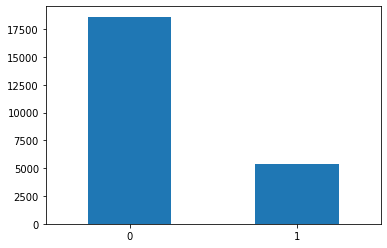

In [13]:
# calculate the ratio of 'default' in the training set
print(df_train['default'].sum() / len(df_train['default']))

df_train['default'].value_counts().plot.bar(rot=0)

22% Default, 78% No default in the training set. Therefore, **our dataset is imbalanced**.

### 3.2 Data Cleaning

In [14]:
def rename_columns(df):
    # change strange (inconsistent) column name 'PAY_0'
    df = df.rename(columns={'PAY_0':'PAY_1'})
    # shorten the name of the target column
    df = df.rename(columns={'default payment next month':'default'})
    return df

# deal with undocumented Education labels
def clean_edu(df):
    df.loc[(df['EDUCATION'] == 0) | (df['EDUCATION'] == 5) | (df['EDUCATION'] == 6), 'EDUCATION'] = 4
    return df

# deal with undocumented Marriage labels
def clean_marriage(df):
    df.loc[df['MARRIAGE'] == 0, 'MARRIAGE'] = 3
    return df

# deal with undocumented past payments labels
def clean_pay(df):
    for i in range(1, 7):
        df.loc[(df[f'PAY_{i}'] == 0), f'PAY_{i}'] = -1
    return df

In [15]:
def cleaning_pipline(df):
    """
    Available functions:
    rename_pay, clean_edu, clean_marriage, clean_pay
    """
    for func in [rename_columns, clean_edu, clean_marriage, clean_pay]:
        df = func(df)
    
    print("Cleaned Data")
    return df

In [16]:
transformed_train = cleaning_pipline(df_train)
transformed_test = cleaning_pipline(df_test)

Cleaned Data
Cleaned Data


### 3.3 Exploratory Data Analysis
1. Draw bar charts to investigate categorical variables (SEX, MARRIAGE, EDUCATION). 
<br>See how the training dataset is divided and if there are sparse classes which can cause overfit of the model.
2. Draw histograms to investigate numerical variables (LIMIT_BAL, AGE, BILL_AMT, PAY_AMT). 
<br>Check the distribution and the presence of extreme values.
3. Draw box plots and heatmapes to investigate features correlations.
4. Features importance test. 

**3.3.1 Check categorical variable's distribution (with bar charts)**

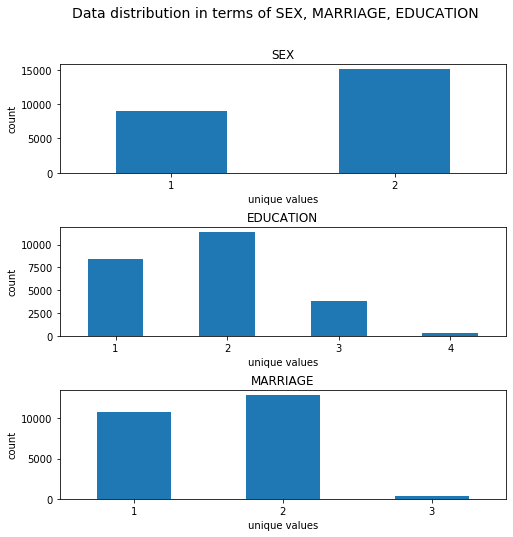

In [17]:
fig, axes = plt.subplots(nrows=3, figsize=(8,8))
fig.suptitle('Data distribution in terms of SEX, MARRIAGE, EDUCATION', fontsize=14)

transformed_train['SEX'].value_counts().sort_index().plot.bar(ax=axes[0], rot=0)
transformed_train['EDUCATION'].value_counts().sort_index().plot.bar(ax=axes[1], rot=0)
transformed_train['MARRIAGE'].value_counts().sort_index().plot.bar(ax=axes[2], rot=0)
axes[0].set_title('SEX')
axes[1].set_title('EDUCATION')
axes[2].set_title('MARRIAGE')

for ax in axes.flat:
    ax.set(xlabel='unique values', ylabel='count')

plt.subplots_adjust(hspace=0.5)
plt.show()

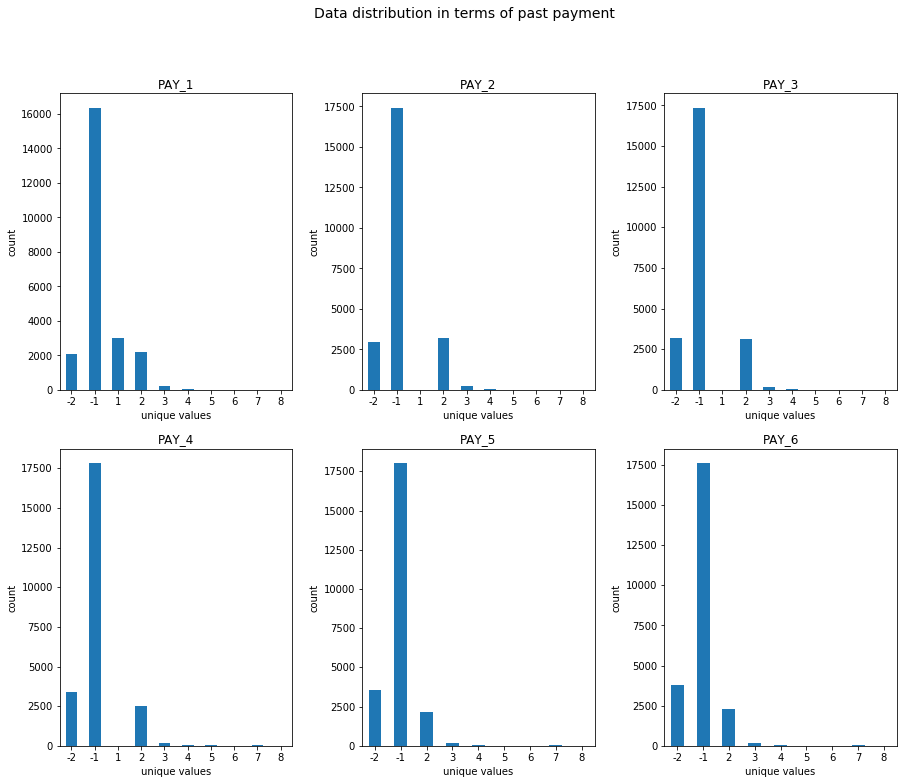

In [18]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15,12))
fig.suptitle('Data distribution in terms of past payment', fontsize=14)

transformed_train['PAY_1'].value_counts().sort_index().plot.bar(ax=axes[0,0], rot=0)
transformed_train['PAY_2'].value_counts().sort_index().plot.bar(ax=axes[0,1], rot=0)
transformed_train['PAY_3'].value_counts().sort_index().plot.bar(ax=axes[0,2], rot=0)
transformed_train['PAY_4'].value_counts().sort_index().plot.bar(ax=axes[1,0], rot=0)
transformed_train['PAY_5'].value_counts().sort_index().plot.bar(ax=axes[1,1], rot=0)
transformed_train['PAY_6'].value_counts().sort_index().plot.bar(ax=axes[1,2], rot=0)

axes[0,0].set_title('PAY_1')
axes[0,1].set_title('PAY_2')
axes[0,2].set_title('PAY_3')
axes[1,0].set_title('PAY_4')
axes[1,1].set_title('PAY_5')
axes[1,2].set_title('PAY_6')

for ax in axes.flat:
    ax.set(xlabel='unique values', ylabel='count')

plt.subplots_adjust(hspace=0.2, wspace=0.3)
plt.show()

Observations: In general, no extreme distribution in meaningful SEX, MARRIAGE, EDUCATION labels (i.e. apart from *others*). So they won't cause overfit of the model.
- More females than males.
- More graduate school and university education level than high school.
- Less frequent the *other* status is in Marriage.


However, the majority of past payments is *pay duly*, which aligns with the imbalanced nature of our training set. We would deal with this at a later stage.

**3.3.2 Check numerical variable's distribution (with histograms)**

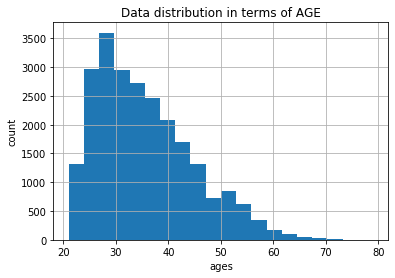

In [19]:
ax = transformed_train['AGE'].hist(bins=20)
ax.set(xlabel='ages', ylabel='count')
plt.title('Data distribution in terms of AGE')
plt.show()

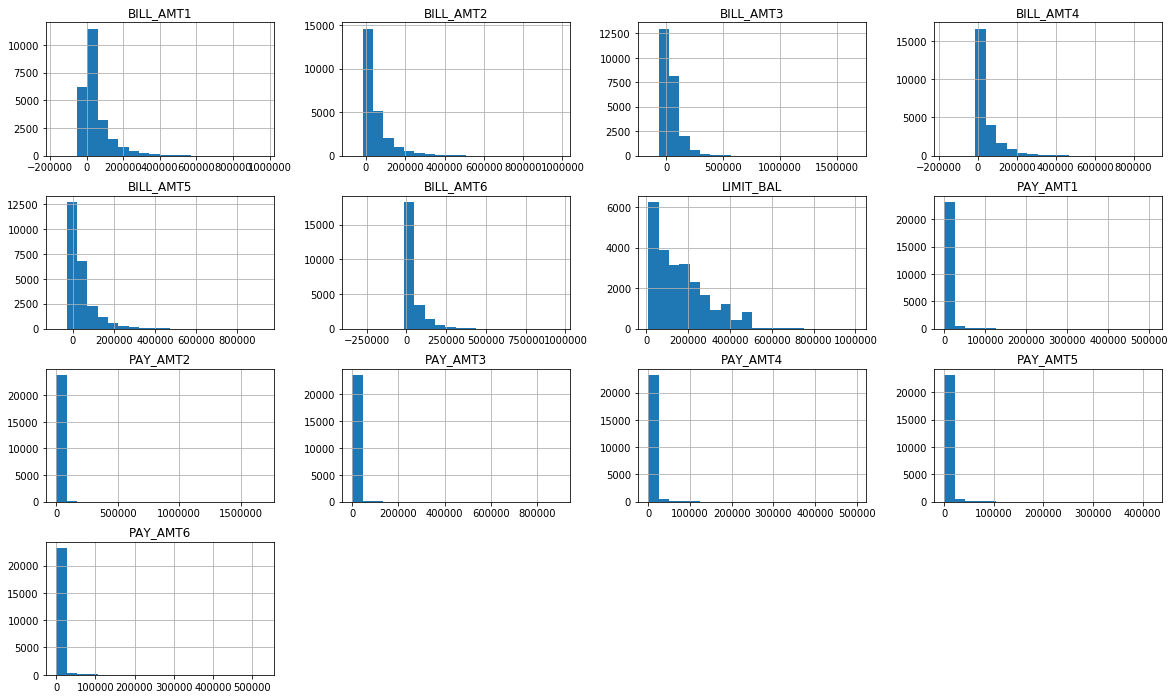

In [20]:
fig= plt.figure(figsize=(20,12))
ax = fig.gca()
fig.suptitle('Data distribution in terms of bill statements (BILL_AMT), credit (LIMIT_BAL) and previous payments (PAY_AMT)', fontsize=14)

transformed_train[numerical_features].hist(ax=ax, bins=20)
plt.show()

Observations:
- No extreme distribution existed in AGE.
- LIMIT_BAL, BILL_AMT and PAY_AMT all have a few extremely large values. These values have been checked in **Data Exploration** phase to be treated as normal data points.

**3.3.3 Check features correlation (with box plot and heatmaps)**

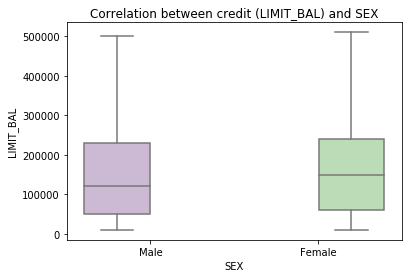

In [21]:
# check given credit vs. sex
ax = sns.boxplot(x="SEX", y="LIMIT_BAL", hue="SEX", data=transformed_train, palette="PRGn",showfliers=False)
ax.legend_.remove()
ax.set_title('Correlation between credit (LIMIT_BAL) and SEX')

# interpret the unique values in xticks
xlabels = [item.get_text() for item in ax.get_xticklabels()]
sex_encoder = {'1':'Male', '2':'Female'}
xlabels = [sex_encoder.get(xlabels[i]) for i in range(len(xlabels))]
ax.set_xticklabels(xlabels)

plt.show()

Observations: The given credit is quite balanced between sexes. Males have a slightly smaller Q1 and mean.

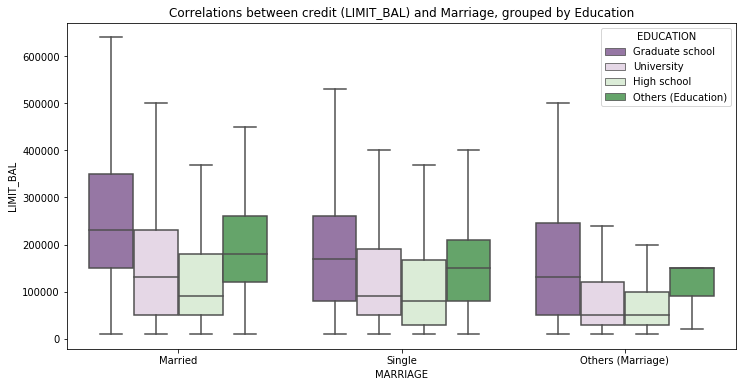

In [22]:
# credit grouped by marriage status and education level
fig, ax = plt.subplots(figsize=(12, 6))
sns.boxplot(ax=ax, x='MARRIAGE', y='LIMIT_BAL', hue='EDUCATION', data=transformed_train, palette="PRGn",showfliers=False)

# interpret the unique values (of EDUCATION) in legend
education_encoder = {'1':'Graduate school', '2':'University', '3':'High school', '4': 'Others (Education)'}
L = plt.legend()
L.set_title('EDUCATION')
for i in range(len(L.get_texts())):
    legend_text = L.get_texts()[i].get_text()
    L.get_texts()[i].set_text(education_encoder.get(legend_text))

# interpret the unique values (of MARRIAGE) in xticks
xlabels = [item.get_text() for item in ax.get_xticklabels()]
marriage_encoder = {'1':'Married', '2':'Single', '3':'Others (Marriage)'}
xlabels = [marriage_encoder.get(xlabels[i]) for i in range(len(xlabels))]
ax.set_xticklabels(xlabels)

plt.title('Correlations between credit (LIMIT_BAL) and Marriage, grouped by Education')
plt.show()

Observations: In general, higher education level has higher credit among all marriage groups. Married people have higher credit than Single than Others among all education levels.

In [23]:
# plot heatmap for a certain set of numerical variables
def check_correlation(variables, title:str):
    plt.figure(figsize=(10,8))
    plt.title(title + ' (Apr 2005 to Sep 2005)' + '\nCorrelation Plot')
    corr = transformed_train[variables].corr()
    sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,linewidths=.1,vmin=-1, vmax=1)
    plt.show()

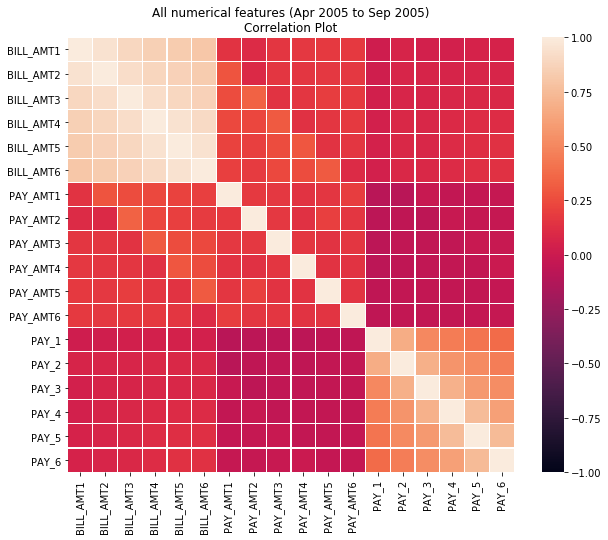

In [24]:
# check the correlation between all numerical variables
check_correlation(['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
                   'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
                   'PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6'], 'All numerical features')

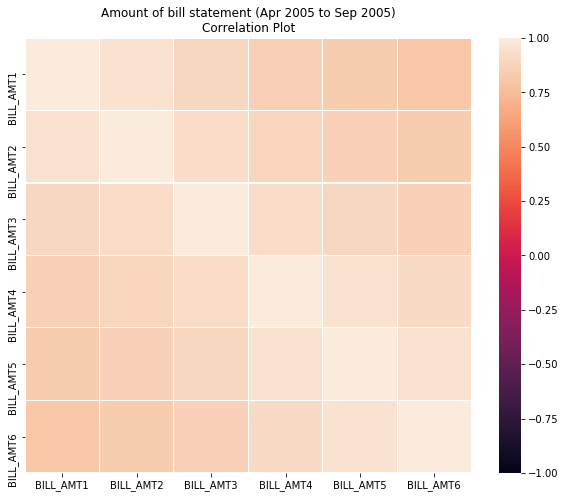

In [25]:
# check the correlation between bill statements
check_correlation(['BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6'], 'Amount of bill statement')

Observations: Correlation is decreasing as the distance between months increases. The lowest correlation is between Sept (BILL_AMT1) & April (BILL_AMT6).

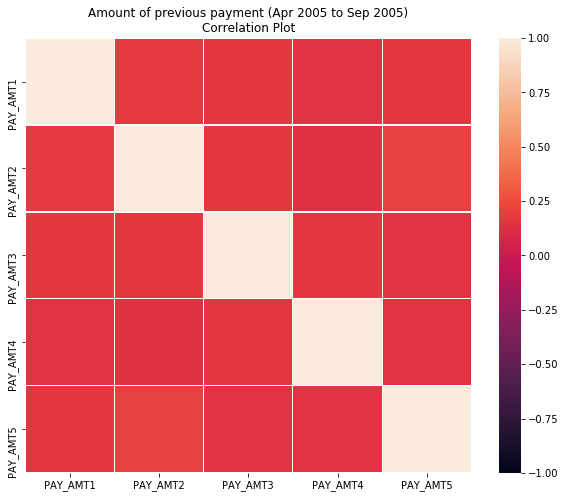

In [26]:
# check the correlation betwee previous payments
check_correlation(['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5'], 'Amount of previous payment')

Observations: There are no obvious correlations between the amounts of previous payments.

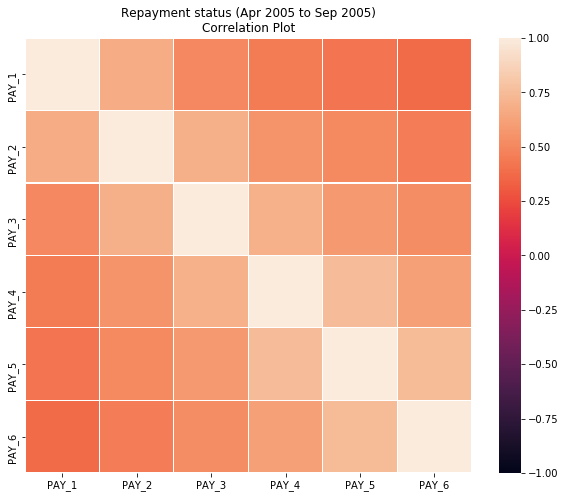

In [27]:
# check the correlation between Repayment status
check_correlation(['PAY_1','PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6'], 'Repayment status')

Observations: Correlation is decreasing as the distance between months increases. The lowest correlation is between Sept (BILL_AMT1) & April (BILL_AMT6). **The repayment status and the bill statements have a similar distribution.**

**3.3.4 Features Importance Test**
<br>Use of any classification model and feed raw data without any splitting and cross validation. This is purely to get a general understanding of importance of features and to set a certain goal for data transformation as part of exploration.

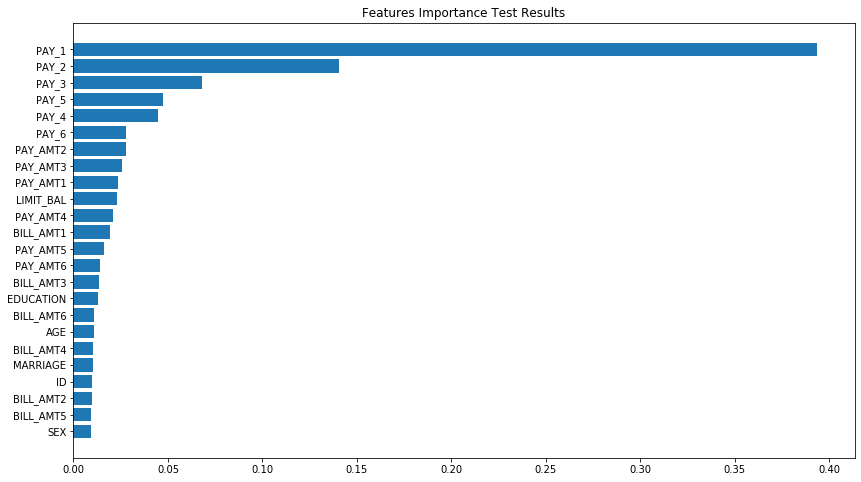

In [28]:
# split training data into X and y
X = transformed_train.drop(['default'], axis=1)
y = transformed_train[['default']]

# fit model with training data
model = XGBClassifier()
model.fit(X, y)

# Get feature name place number
features_num = [i for i in range(len(model.feature_importances_))]
importance = model.feature_importances_.tolist()
feature_names = X.columns

# Sorting
matched = zip(features_num, feature_names, importance)
sorted_importance = sorted(matched, key=lambda x: x[2])       # sort by importance

sorted_features_importance = list(map(lambda x: x[2], sorted_importance))
sorted_features_names = list(map(lambda x: x[1], sorted_importance))

fig = plt.figure(figsize=(14, 8))
plt.barh(features_num, sorted_features_importance, tick_label=sorted_features_names)
plt.title('Features Importance Test Results')
plt.show()

Observations:
1. PAY_N is the most important feature, so we will not change these features during transformation phase.
2. Generally, PAY_N > PAY_AMT >LIMIT_BAL > BILL_AMT. Therefore we can try to use BILL_AMTs and try making stronger and semantically meaningful features by combining weak features.
3. Among 4 personal information (*Education, Marriage, Age, Sex*), Education is the most important feature. On the other hand, Marriage, Age & Sex are contributing very little to the classification. 

### 3.4 Feature Engineering
In this section, we conducted feature engineering based on the insights obtained from **Exploratory Data Analysis**. It contains three main parts of transformation: 1) feature processing; 2) remedy for imbalanced training set using **Borerline-SMOTE**; 3) feature scaling.

**3.4.1 Feature processing**

In [8]:
def drop_id(df):
    df = df.drop(['ID'], axis=1)
    return df

# combine SEX and MARRIAGE, encode each unique combination with an integer values [1,6]
# this can reduce the dimension of the dataset
def combine_gender_marital(df):
    df['SEX_MAR'] = 0  # placeholder for integer values
    # encoding
    df.loc[(df['SEX'] == 1) & (df['MARRIAGE'] == 1), 'SEX_MAR'] = 1
    df.loc[(df['SEX'] == 1) & (df['MARRIAGE'] == 2), 'SEX_MAR'] = 2
    df.loc[(df['SEX'] == 1) & (df['MARRIAGE'] == 3), 'SEX_MAR'] = 3
    df.loc[(df['SEX'] == 2) & (df['MARRIAGE'] == 1), 'SEX_MAR'] = 4
    df.loc[(df['SEX'] == 2) & (df['MARRIAGE'] == 2), 'SEX_MAR'] = 5
    df.loc[(df['SEX'] == 2) & (df['MARRIAGE'] == 3), 'SEX_MAR'] = 6
    
    df = df.drop(['SEX', 'MARRIAGE'], axis=1)
    print('combined gender & marital')
    return df

# further categorise ages in step 10
def make_age_bins(df):
    df['AgeBin'] = 0 # placeholder for integer values
    df.loc[((df['AGE'] < 30)) , 'AgeBin'] = 1
    df.loc[((df['AGE'] >= 30) & (df['AGE'] < 40)) , 'AgeBin'] = 2
    df.loc[((df['AGE'] >= 40) & (df['AGE'] < 50)) , 'AgeBin'] = 3
    df.loc[((df['AGE'] >= 50) & (df['AGE'] < 60)) , 'AgeBin'] = 4
    df.loc[((df['AGE'] >= 60) & (df['AGE'] < 70)) , 'AgeBin'] = 5
    df.loc[((df['AGE'] >= 70) & (df['AGE'] < 81)) , 'AgeBin'] = 6
    
    df = df.drop(['AGE'], axis=1)
    print('made age bins')
    return df

# create 6 new features, 'Closeness_1' to 'Closeness_6', which calculates the difference 
# between credit (LIMIT_BAL) and each bill statement.
def get_closeness(df):
    for i in range(1, 7):
        df[f'Closeness_{i}'] = (df.LIMIT_BAL - df[f'BILL_AMT{i}']) #/ df.LIMIT_BAL
    
    print('added closeness')
    return df

# create a new feature called 'diff' that calculates the difference between the sum of 
# bill statements (BIL_AMT1 to BIL_AMT6) and the sum of previous payments (PAY_AMT1 to PAY_AMT6)
def get_diff_of_totals(df):
    df['diff'] = 0   # placeholder for integer values
    
    bill_cols = [f'BILL_AMT{i}' for i in range(1, 7)]
    pay_cols = [f'PAY_AMT{i}' for i in range(1, 7)]
    
    for index, row in df.iterrows():
        bill_df = df.loc[index, bill_cols]
        pay_df = df.loc[index, pay_cols]

        bill_sum = np.sum(bill_df.values)
        pay_sum = np.sum(pay_df.values)

        df.loc[index, 'diff'] = bill_sum - pay_sum
    
    print('added diff')
    return df

def drop_bill_amt(df):
    df = df.drop([f'BILL_AMT{i}' for i in range(1, 7)], axis=1)
    return df

def drop_pay_amt(df):
    df = df.drop([f'PAY_AMT{i}' for i in range(1, 7)], axis=1)
    return df

def drop_age(df):
    df = df.drop(['AGE'], axis=1)
    return df

In [9]:
def processing_pipline(df):
    """
    Available functions:
    drop_id, combine_gender_marital, make_age_bins, get_closeness, get_diff_of_totals, drop_bill_amt, drop_pay_amt, drop_age
    """
    for func in [drop_id, combine_gender_marital, make_age_bins, get_closeness, get_diff_of_totals]:
        df = func(df)
    
    print("Transformed Features")
    
    return df

In [10]:
transformed_train = processing_pipline(transformed_train)
transformed_test = processing_pipline(transformed_test)

combined gender & marital
made age bins
added closeness
added diff
Transformed Features
combined gender & marital
made age bins
added closeness
added diff
Transformed Features


In [11]:
# re-order features
transformed_train = transformed_train[['LIMIT_BAL', 'EDUCATION', 'SEX_MAR', 'AgeBin', 'diff',
                                       'PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 
                                       'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 
                                       'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 
                                       'Closeness_1', 'Closeness_2', 'Closeness_3','Closeness_4', 'Closeness_5', 'Closeness_6', 
                                       'default']]
transformed_test = transformed_test[['LIMIT_BAL', 'EDUCATION', 'SEX_MAR', 'AgeBin', 'diff',
                                     'PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 
                                     'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 
                                     'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 
                                     'Closeness_1', 'Closeness_2', 'Closeness_3','Closeness_4', 'Closeness_5', 'Closeness_6', 
                                     'default']]

### 3.4.2 Dealing with an imabalanced dataset
The training set is imbalanced since the ratio of Default to No Default is about 2:8. We adopted the SMOTE oversampling technique for remedy.
<br>Reference: https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

**SMOTE vs. Borderline-SMOTE**
<br>We first generalised an imbalanced classes with 2 features to compare the performance of  **SMOTE** and **Borderline-SMOTE**.

Counter({0: 9900, 1: 100})


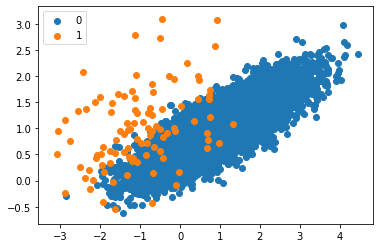

In [19]:
# Simulated data with 10000 samples and the radio of 0 and 1 is 0.99.
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0, n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=1)
counter = Counter(y)
print(counter)

for label, _ in counter.items():
    row_ix = where(y == label)[0]
    plt.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
plt.legend()
plt.show()

Counter({0: 9900, 1: 9900})


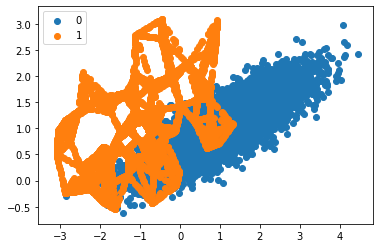

In [20]:
# Handle the data by using SMOTE method and plot the scatter graph
oversample = SMOTE()
X_test_smote, y_test_smote = oversample.fit_sample(X, y)
counter = Counter(y_test_smote)
print(counter)

for label, _ in counter.items():
    row_ix = where(y_test_smote == label)[0]
    plt.scatter(X_test_smote[row_ix, 0], X_test_smote[row_ix, 1], label=str(label))
plt.legend()
plt.show()

From the graph, we can observe that all the minority samples are used to generate new synthetic data.

To improve the algorithm, we use Boarderline-SMOTE to regenerate the syntnetic samples:


Counter({0: 9900, 1: 9900})


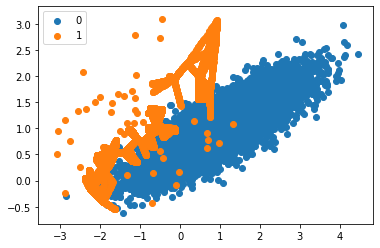

In [21]:
oversample = BorderlineSMOTE(random_state=42, kind="borderline-1")
X_test_BS, y_test_BS = oversample.fit_sample(X, y)
counter = Counter(y_test_BS)
print(counter)

for label, _ in counter.items():
    row_ix = where(y_test_BS == label)[0]
    plt.scatter(X_test_BS[row_ix, 0], X_test_BS[row_ix, 1], label=str(label))
plt.legend()
plt.show()

After applying Borderline-SMOTE, minorty samples which are far away from the decision boundary are not taken to generate new synthetic samples. Minority samples which are overlapped with the majority samples are not used to generate new synthetic samples as well. 

As a result, **we decided to apply borderline-SMOTE on Credit Card Default data**:

In [12]:
# borderline_SMOTE provided data with less probability to overfit
def Borderline_SMOTE(df):
    oversample = BorderlineSMOTE(random_state=42, kind="borderline-1")
    y_train = df['default'].copy()
    X_train = df.copy()
    X_train = X_train.drop(['default'], axis = 1)
    
    X_borderline_smote, y_borderline_smote = oversample.fit_sample(X_train, y_train)
    counter = Counter(y_borderline_smote)
    print(counter)
    print("Probability of default is 1: ", y_borderline_smote.sum() / len(y_borderline_smote))
    
    return X_borderline_smote, y_borderline_smote

In [13]:
X_train_oversampled, y_train_oversampled = Borderline_SMOTE(transformed_train)
print("X_train_oversampled shape:", X_train_oversampled.shape)
print("y_train_oversampled shape:", y_train_oversampled.shape)

Counter({1: 18630, 0: 18630})
Probability of default is 1:  0.5
X_train_oversampled shape: (37260, 29)
y_train_oversampled shape: (37260,)


Now, the ratio of Default is balanced. We obtained 37260 samples for training.

### 3.4.3 Feature scaling: Normalisation or Standardization
NOTE: Feature scaling of training data has to be done with test data with the same scale.
<br> Set up 2 sets of training & test data: 1) SMOTEd version; 2) non-SMOTEd version.

In [12]:
# split target column
x_train = transformed_train.drop(['default'], axis = 1)
y_train = transformed_train['default'].copy()

x_test = transformed_test.drop(['default'], axis = 1)
y_test = transformed_test['default'].copy()

In [13]:
# scaling non-oversampled training & test data
scaler = MinMaxScaler().fit(x_train)
x_train_nos, x_test_nos = scaler.transform(x_train), scaler.transform(x_test)

y_train_nos = y_train

print("Non-oversampled x_train has shape", x_train_nos.shape)
print("Non-oversampled x_test has shape", x_test_nos.shape)

Non-oversampled x_train has shape (24000, 29)
Non-oversampled x_test has shape (6000, 29)


In [16]:
# scaling oversampled training & test data
scaler_os = MinMaxScaler().fit(X_train_oversampled)
x_train_oversampled, x_test_oversampled = scaler_os.transform(X_train_oversampled), scaler_os.transform(x_test)

print("Oversampled x_train has shape", x_train_oversampled.shape)
print("Oversampled x_test has shape", x_test_oversampled.shape)

Oversampled x_train has shape (37260, 29)
Oversampled x_test has shape (6000, 29)


# **4. Methodology**

In this section, we tried 5 different methodologies from three main categories: Decision Trees(**AdaBoost**, **XGBoost** and **Gradient Boosting**), **Random Forest** and **Artificial Neural Networks**. For each methodology, we trained a oversampled and non-oversampled version (10 models in total). The evaluation metrics used to compare the prediction performances are: **accuracy score, f1 score, false positive (FP) rate and false negative (FN) rate**. 
<br>Finally, after comparing the prediction performances, we chose non-oversampled XGBoost as our final methodology.

**Variables' names index:**
- **For non-oversampled training**: x_train_nos, y_train_nos, x_test_nos, y_test.
- **For oversampled training**: x_train_oversampled, y_train_oversampled, x_test_oversampled, y_test.

In [17]:
# create a DataFrame to hold the evalutation results for each model
models_evals = pd.DataFrame(index=['AdaBoost (oversampled)', 'AdaBoost (non-oversampled)', 
                                   'Random Forest (oversampled)', 'Random Forest (non-oversampled)', 
                                   'GBRT (oversampled)', 'GBRT (non-oversampled)', 
                                   'ANN (oversampled)', 'ANN (non-oversampled)', 
                                   'XGBoost (oversampled)', 'XGBoost (non-oversampled)'],
                           columns=['accuracy', 'f1', 'FP rate', 'FN rate'])
models_evals

,accuracy,f1,FP rate,FN rate
AdaBoost (oversampled),NaN,NaN,NaN,NaN
AdaBoost (non-oversampled),NaN,NaN,NaN,NaN
Random Forest (oversampled),NaN,NaN,NaN,NaN
Random Forest (non-oversampled),NaN,NaN,NaN,NaN
GBRT (oversampled),NaN,NaN,NaN,NaN
GBRT (non-oversampled),NaN,NaN,NaN,NaN
ANN (oversampled),NaN,NaN,NaN,NaN
ANN (non-oversampled),NaN,NaN,NaN,NaN
XGBoost (oversampled),NaN,NaN,NaN,NaN
XGBoost (non-oversampled),NaN,NaN,NaN,NaN


In [49]:
# used in 4.1, 4.2, 4.3, 4.4, 4.5 and section 7
def cal_FP_FN(y_true, y_pred):
    # compute the confusion metrix
    cm = pd.DataFrame(confusion_matrix(y_true, y_pred), 
                      columns=['No Default', 'Default'], index = ['No Default', 'Default'])
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    
    # FP = the number of incorrect positive predictions / the total number of negatives
    fp = cm.loc['No Default','Default']/cm.loc['No Default',:].sum()
    
    # FN = the number of incorrect negative predictions / the total number of positives
    fn = cm.loc['Default','No Default']/cm.loc['Default',:].sum()
    
    return fp, fn

In [19]:
# used in 4.1, 4.2, 4.3
def train_and_cross_validate(model, x_train, y_train, prompt, n_splits=5):
    n_iter = 1      # this var is made just to keep track of the number of iteration
    kfold = KFold(n_splits=n_splits)
    cv_accuracy = []

    for train_idx, val_idx in kfold.split(x_train):
        x_train_cv, x_val = x_train[train_idx], x_train[val_idx]
        y_train_cv, y_val = y_train[train_idx], y_train[val_idx]

        model.train(x_train_cv, y_train_cv)
        pred = model.predict(x_val)

        accuracy = np.round(accuracy_score(y_val, pred), 3)

        print("Iteration : {}, Cross-Validation Accuracy : {}".format(n_iter, accuracy))

        n_iter += 1

        cv_accuracy.append(accuracy)

    print("Average accuracy for", prompt, ":", np.mean(cv_accuracy))

## 4.1 AdaBoost

### 4.1.1 Model Training

In [20]:
class adaboost(object):
    def __init__(self):
        # build the model
        self.model = ensemble.AdaBoostClassifier(n_estimators=200,learning_rate=0.001)

    def train(self, x_train, y_train):
        # training
        self.model.fit(x_train,y_train)

    def predict(self, x_test):
        # predicting
        y_pred = self.model.predict(x_test)

        return y_pred

In [21]:
# train Adaboost model with non-oversampled data
adaboost_model = adaboost()
train_and_cross_validate(adaboost_model, x_train_nos, y_train_nos, "Adaboost (non-oversampled)")

Iteration : 1, Cross-Validation Accuracy : 0.805
Iteration : 2, Cross-Validation Accuracy : 0.807
Iteration : 3, Cross-Validation Accuracy : 0.812
Iteration : 4, Cross-Validation Accuracy : 0.822
Iteration : 5, Cross-Validation Accuracy : 0.838
Average accuracy for Adaboost (non-oversampled) : 0.8168000000000001


In [22]:
# train Adaboost model with oversampled data
adaboost_model_os = adaboost()
train_and_cross_validate(adaboost_model_os, x_train_oversampled, y_train_oversampled, "Adaboost (oversampled)")

Iteration : 1, Cross-Validation Accuracy : 0.766
Iteration : 2, Cross-Validation Accuracy : 0.77
Iteration : 3, Cross-Validation Accuracy : 0.79
Iteration : 4, Cross-Validation Accuracy : 0.74
Iteration : 5, Cross-Validation Accuracy : 0.722
Average accuracy for Adaboost (oversampled) : 0.7575999999999999


### **4.1.2 Results**

**Results for non-oversampled Adaboost**

In [23]:
# prediction
y_pred_adaboost = adaboost_model.predict(x_test_nos)

# evaluation metrics
accuracy_adaboost = accuracy_score(y_test, y_pred_adaboost)
f1_adaboost = f1_score(y_test, y_pred_adaboost)
fp_adaboost, fn_adaboost = cal_FP_FN(y_test, y_pred_adaboost)

print(f"Accuracy score for Adaboost (non-oversampled): {accuracy_adaboost:.3f}")
print(f"f1 score for Adaboost (non-oversampled): {f1_adaboost:.3f}")
print(f"False Positive rate for Adaboost (non-oversampled): {fp_adaboost:.3f}")
print(f"False Negative rate for Adaboost (non-oversampled): {fn_adaboost:.3f}")

# store the evaluation results
models_evals.loc['AdaBoost (non-oversampled)', 'accuracy'] = round(accuracy_adaboost, 3)
models_evals.loc['AdaBoost (non-oversampled)', 'f1'] = round(f1_adaboost, 3)
models_evals.loc['AdaBoost (non-oversampled)', 'FP rate'] = round(fp_adaboost, 3)
models_evals.loc['AdaBoost (non-oversampled)', 'FN rate'] = round(fn_adaboost, 3)

Accuracy score for Adaboost (non-oversampled): 0.831
f1 score for Adaboost (non-oversampled): 0.448
False Positive rate for Adaboost (non-oversampled): 0.034
False Negative rate for Adaboost (non-oversampled): 0.675


**Results for oversampled Adaboost**

In [24]:
# prediction
y_pred_adaboost_os = adaboost_model_os.predict(x_test_oversampled)

# evaluation metrics
accuracy_adaboost_os = accuracy_score(y_test, y_pred_adaboost_os)
f1_adaboost_os = f1_score(y_test, y_pred_adaboost_os)
fp_adaboost_os, fn_adaboost_os = cal_FP_FN(y_test, y_pred_adaboost_os)

print(f"Accuracy score for Adaboost (oversampled): {accuracy_adaboost_os:.3f}")
print(f"f1 score for Adaboost (oversampled): {f1_adaboost_os:.3f}")
print(f"False Positive rate for Adaboost (oversampled): {fp_adaboost_os:.3f}")
print(f"False Negative rate for Adaboost (oversampled): {fn_adaboost_os:.3f}")

# store the evaluation results
models_evals.loc['AdaBoost (oversampled)', 'accuracy'] = round(accuracy_adaboost_os, 3)
models_evals.loc['AdaBoost (oversampled)', 'f1'] = round(f1_adaboost_os, 3)
models_evals.loc['AdaBoost (oversampled)', 'FP rate'] = round(fp_adaboost_os, 3)
models_evals.loc['AdaBoost (oversampled)', 'FN rate'] = round(fn_adaboost_os, 3)

Accuracy score for Adaboost (oversampled): 0.794
f1 score for Adaboost (oversampled): 0.512
False Positive rate for Adaboost (oversampled): 0.131
False Negative rate for Adaboost (oversampled): 0.487


## **4.2 Random Forest**

### **4.2.1 Model Traning**

In [26]:
class random_forest(object):
    def __init__(self):
        # create the model
        self.model = ensemble.BaggingClassifier(KNeighborsClassifier(), n_estimators=200, max_samples=0.5,max_features=0.5)

    def train(self,x_train,y_train):
        # training
        self.model.fit(x_train,y_train)

    def predict(self,x_test):
        # predicting
        y_pred = self.model.predict(x_test)
        return y_pred

In [27]:
# train Random Forest model with non-oversampled data
random_forest_model = random_forest()
train_and_cross_validate(random_forest_model, x_train_nos, y_train_nos, "Random Forest (non-oversampled)")

Iteration : 1, Cross-Validation Accuracy : 0.796
Iteration : 2, Cross-Validation Accuracy : 0.802
Iteration : 3, Cross-Validation Accuracy : 0.801
Iteration : 4, Cross-Validation Accuracy : 0.805
Iteration : 5, Cross-Validation Accuracy : 0.829
Average accuracy for Random Forest (non-oversampled) : 0.8066000000000001


In [28]:
# train Random Forest model with oversampled data
random_forest_model_os = random_forest()
train_and_cross_validate(random_forest_model_os, x_train_oversampled, y_train_oversampled, "Random Forest (oversampled)")

Iteration : 1, Cross-Validation Accuracy : 0.751
Iteration : 2, Cross-Validation Accuracy : 0.756
Iteration : 3, Cross-Validation Accuracy : 0.764
Iteration : 4, Cross-Validation Accuracy : 0.868
Iteration : 5, Cross-Validation Accuracy : 0.836
Average accuracy for Random Forest (oversampled) : 0.7949999999999999


### **4.2.2 Results**

**Results for non-oversampled Random Forest**

In [29]:
# prediction
y_pred_random_forest = random_forest_model.predict(x_test_nos)

# evaluation metrics
accuracy_random_forest = accuracy_score(y_test, y_pred_random_forest)
f1_random_forest = f1_score(y_test, y_pred_random_forest)
fp_random_forest, fn_random_forest = cal_FP_FN(y_test, y_pred_random_forest)

print(f"Accuracy score for Random Forest (non-oversampled): {accuracy_random_forest:.3f}")
print(f"f1 score for Random Forest (non-oversampled): {f1_random_forest:.3f}")
print(f"False Positive rate for Random Forest (non-oversampled): {fp_random_forest:.3f}")
print(f"False Negative rate for Random Forest (non-oversampled): {fn_random_forest:.3f}")

# store the evaluation results
models_evals.loc['Random Forest (non-oversampled)', 'accuracy'] = round(accuracy_random_forest, 3)
models_evals.loc['Random Forest (non-oversampled)', 'f1'] = round(f1_random_forest, 3)
models_evals.loc['Random Forest (non-oversampled)', 'FP rate'] = round(fp_random_forest, 3)
models_evals.loc['Random Forest (non-oversampled)', 'FN rate'] = round(fn_random_forest, 3)

Accuracy score for Random Forest (non-oversampled): 0.821
f1 score for Random Forest (non-oversampled): 0.370
False Positive rate for Random Forest (non-oversampled): 0.026
False Negative rate for Random Forest (non-oversampled): 0.750


**Results for oversampled Random Forest**

In [30]:
# prediction
y_pred_random_forest_os = random_forest_model_os.predict(x_test_oversampled)

# evaluation metrics
accuracy_random_forest_os = accuracy_score(y_test, y_pred_random_forest_os)
f1_random_forest_os = f1_score(y_test, y_pred_random_forest_os)
fp_random_forest_os, fn_random_forest_os = cal_FP_FN(y_test, y_pred_random_forest_os)

print(f"Accuracy score for Random Forest (oversampled): {accuracy_random_forest_os:.3f}")
print(f"f1 score for Random Forest (oversampled): {f1_random_forest_os:.3f}")
print(f"False Positive rate for Random Forest (oversampled): {fp_random_forest_os:.3f}")
print(f"False Negative rate for Random Forest (oversampled): {fn_random_forest_os:.3f}")

# store the evaluation results
models_evals.loc['Random Forest (oversampled)', 'accuracy'] = round(accuracy_random_forest_os, 3)
models_evals.loc['Random Forest (oversampled)', 'f1'] = round(f1_random_forest_os, 3)
models_evals.loc['Random Forest (oversampled)', 'FP rate'] = round(fp_random_forest_os, 3)
models_evals.loc['Random Forest (oversampled)', 'FN rate'] = round(fn_random_forest_os, 3)

Accuracy score for Random Forest (oversampled): 0.817
f1 score for Random Forest (oversampled): 0.464
False Positive rate for Random Forest (oversampled): 0.065
False Negative rate for Random Forest (oversampled): 0.625


## **4.3 GBRT**

### **4.3.1 Model Training**

In [31]:
class GBRT(object):
    def __init__(self):
        # create the model
        self.model = ensemble.GradientBoostingClassifier(n_estimators=200)

    def train(self,x_train,y_train):
        # training
        self.model.fit(x_train,y_train)

    def predict(self,x_test):
        # predicting
        y_pred = self.model.predict(x_test)
        return y_pred

In [32]:
# train GBRT model with non-oversampled data
GBRT_model = GBRT()
train_and_cross_validate(GBRT_model, x_train_nos, y_train_nos, "GBRT (non-oversampled)")

Iteration : 1, Cross-Validation Accuracy : 0.805
Iteration : 2, Cross-Validation Accuracy : 0.809
Iteration : 3, Cross-Validation Accuracy : 0.806
Iteration : 4, Cross-Validation Accuracy : 0.822
Iteration : 5, Cross-Validation Accuracy : 0.84
Average accuracy for GBRT (non-oversampled) : 0.8164


In [33]:
# train GBRT model with oversampled data
GBRT_model_os = GBRT()
train_and_cross_validate(GBRT_model_os, x_train_oversampled, y_train_oversampled, "GBRT (non-oversampled)")

Iteration : 1, Cross-Validation Accuracy : 0.766
Iteration : 2, Cross-Validation Accuracy : 0.767
Iteration : 3, Cross-Validation Accuracy : 0.792
Iteration : 4, Cross-Validation Accuracy : 0.852
Iteration : 5, Cross-Validation Accuracy : 0.833
Average accuracy for GBRT (non-oversampled) : 0.8019999999999999


### **4.3.2 Results**

**Results for non-oversampled GBRT**

In [34]:
# prediction
y_pred_GBRT = GBRT_model.predict(x_test_nos)

# evaluation metrics
accuracy_GBRT = accuracy_score(y_test, y_pred_GBRT)
f1_GBRT = f1_score(y_test, y_pred_GBRT)
fp_GBRT, fn_GBRT = cal_FP_FN(y_test, y_pred_GBRT)

print(f"Accuracy score for GBRT (non-oversampled): {accuracy_GBRT:.3f}")
print(f"f1 score for GBRT (non-oversampled): {f1_GBRT:.3f}")
print(f"False Positive rate for GBRT (non-oversampled): {fp_GBRT:.3f}")
print(f"False Negative rate for GBRT (non-oversampled): {fn_GBRT:.3f}")

# store the evaluation results
models_evals.loc['GBRT (non-oversampled)', 'accuracy'] = round(accuracy_GBRT, 3)
models_evals.loc['GBRT (non-oversampled)', 'f1'] = round(f1_GBRT, 3)
models_evals.loc['GBRT (non-oversampled)', 'FP rate'] = round(fp_GBRT, 3)
models_evals.loc['GBRT (non-oversampled)', 'FN rate'] = round(fn_GBRT, 3)

Accuracy score for GBRT (non-oversampled): 0.831
f1 score for GBRT (non-oversampled): 0.465
False Positive rate for GBRT (non-oversampled): 0.040
False Negative rate for GBRT (non-oversampled): 0.652


**Results for oversampled GBRT**

In [35]:
# prediction
y_pred_GBRT_os = GBRT_model_os.predict(x_test_oversampled)

# evaluation metrics
accuracy_GBRT_os = accuracy_score(y_test, y_pred_GBRT_os)
f1_GBRT_os = f1_score(y_test, y_pred_GBRT_os)
fp_GBRT_os, fn_GBRT_os = cal_FP_FN(y_test, y_pred_GBRT_os)

print(f"Accuracy score for GBRT (oversampled): {accuracy_GBRT_os:.3f}")
print(f"f1 score for GBRT (oversampled): {f1_GBRT_os:.3f}")
print(f"False Positive rate for GBRT (oversampled): {fp_GBRT_os:.3f}")
print(f"False Negative rate for GBRT (oversampled): {fn_GBRT_os:.3f}")

# store the evaluation results
models_evals.loc['GBRT (oversampled)', 'accuracy'] = round(accuracy_GBRT_os, 3)
models_evals.loc['GBRT (oversampled)', 'f1'] = round(f1_GBRT_os, 3)
models_evals.loc['GBRT (oversampled)', 'FP rate'] = round(fp_GBRT_os, 3)
models_evals.loc['GBRT (oversampled)', 'FN rate'] = round(fn_GBRT_os, 3)

Accuracy score for GBRT (oversampled): 0.827
f1 score for GBRT (oversampled): 0.506
False Positive rate for GBRT (oversampled): 0.064
False Negative rate for GBRT (oversampled): 0.580


## **4.4 Artificial Neural Network (ANN)**

### **4.4.1 Data Preparation**

In [36]:
x_train_ann = x_train_nos.copy()
x_train_ann_os = x_train_oversampled.copy()

# make training target as categorial one-hot vector
y_train_ann = to_categorical(y_train_nos, num_classes = 2)
y_train_ann_os = to_categorical(y_train_oversampled, num_classes = 2)

# split validation set
x_train_ann, x_val_ann, y_train_ann, y_val_ann = train_test_split(x_train_ann, y_train_ann, 
                                                                  test_size = 0.1, shuffle=True)
x_train_ann_os, x_val_ann_os, y_train_ann_os, y_val_ann_os = train_test_split(x_train_ann_os, y_train_ann_os, 
                                                                              test_size = 0.1, shuffle=True)
print('non-oversampled:', x_train_ann.shape, x_val_ann.shape, y_train_ann.shape, y_val_ann.shape)
print('oversampled:', x_train_ann_os.shape, x_val_ann_os.shape, y_train_ann_os.shape, y_val_ann_os.shape)

non-oversampled: (21600, 29) (2400, 29) (21600, 2) (2400, 2)
oversampled: (33534, 29) (3726, 29) (33534, 2) (3726, 2)


### **4.4.2 Model Training**

**Set up the model structure**

In [44]:
def model_setup():
    model = Sequential()

    model.add(Dense(256, activation = "relu", input_shape=(29,)))
    model.add(Dropout(0.25))

    model.add(Dense(128, activation = "relu"))
    model.add(Dropout(0.25))

    model.add(Dense(64, activation = "relu"))
    model.add(Dropout(0.25))

    model.add(Dense(32, activation = "relu"))
    model.add(Dropout(0.25))

    model.add(Dense(16, activation = "relu"))

    model.add(Dense(2, activation = "softmax"))
    
    optimizer = Adam(lr=0.001)
    model.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics=["accuracy"])
    
    return model

In [38]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               7680      
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)               

In [40]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)
epochs = 50
batch_size = 64

# Early Stopping
# This callback will stop the training when there is no improvement in
# the validation loss for three consecutive epochs.
callback = EarlyStopping(monitor='loss', patience=3)

In [45]:
# train ANN model with non-oversampled data
ANN_model = model_setup()
history = ANN_model.fit(x_train_ann, y_train_ann, batch_size=batch_size, epochs=epochs,
                        validation_data=(x_val_ann, y_val_ann), verbose=2, callbacks=[callback])

Train on 21600 samples, validate on 2400 samples
Epoch 1/50
 - 1s - loss: 0.4823 - accuracy: 0.7969 - val_loss: 0.4571 - val_accuracy: 0.8083
Epoch 2/50
 - 1s - loss: 0.4603 - accuracy: 0.8057 - val_loss: 0.4533 - val_accuracy: 0.8133
Epoch 3/50
 - 0s - loss: 0.4559 - accuracy: 0.8100 - val_loss: 0.4482 - val_accuracy: 0.8125
Epoch 4/50
 - 0s - loss: 0.4519 - accuracy: 0.8088 - val_loss: 0.4454 - val_accuracy: 0.8146
Epoch 5/50
 - 0s - loss: 0.4493 - accuracy: 0.8113 - val_loss: 0.4479 - val_accuracy: 0.8175
Epoch 6/50
 - 0s - loss: 0.4489 - accuracy: 0.8115 - val_loss: 0.4498 - val_accuracy: 0.8112
Epoch 7/50
 - 1s - loss: 0.4476 - accuracy: 0.8119 - val_loss: 0.4429 - val_accuracy: 0.8167
Epoch 8/50
 - 1s - loss: 0.4455 - accuracy: 0.8125 - val_loss: 0.4442 - val_accuracy: 0.8154
Epoch 9/50
 - 1s - loss: 0.4466 - accuracy: 0.8128 - val_loss: 0.4441 - val_accuracy: 0.8158
Epoch 10/50
 - 1s - loss: 0.4449 - accuracy: 0.8126 - val_loss: 0.4464 - val_accuracy: 0.8179
Epoch 11/50
 - 0s - 

In [46]:
# train ANN model with oversampled data
ANN_model_os = model_setup()
history_os = ANN_model_os.fit(x_train_ann_os, y_train_ann_os, batch_size=batch_size, epochs=epochs,
                              validation_data=(x_val_ann_os, y_val_ann_os), verbose=2, callbacks=[callback])

Train on 33534 samples, validate on 3726 samples
Epoch 1/50
 - 1s - loss: 0.5655 - accuracy: 0.7255 - val_loss: 0.5181 - val_accuracy: 0.7571
Epoch 2/50
 - 1s - loss: 0.5174 - accuracy: 0.7636 - val_loss: 0.4888 - val_accuracy: 0.7754
Epoch 3/50
 - 1s - loss: 0.4962 - accuracy: 0.7695 - val_loss: 0.4614 - val_accuracy: 0.7877
Epoch 4/50
 - 1s - loss: 0.4839 - accuracy: 0.7743 - val_loss: 0.4731 - val_accuracy: 0.7770
Epoch 5/50
 - 1s - loss: 0.4736 - accuracy: 0.7787 - val_loss: 0.4619 - val_accuracy: 0.7858
Epoch 6/50
 - 1s - loss: 0.4655 - accuracy: 0.7802 - val_loss: 0.4460 - val_accuracy: 0.7917
Epoch 7/50
 - 1s - loss: 0.4590 - accuracy: 0.7835 - val_loss: 0.4299 - val_accuracy: 0.7885
Epoch 8/50
 - 1s - loss: 0.4535 - accuracy: 0.7872 - val_loss: 0.4297 - val_accuracy: 0.7928
Epoch 9/50
 - 1s - loss: 0.4491 - accuracy: 0.7873 - val_loss: 0.4288 - val_accuracy: 0.7874
Epoch 10/50
 - 1s - loss: 0.4475 - accuracy: 0.7897 - val_loss: 0.4309 - val_accuracy: 0.7947
Epoch 11/50
 - 1s - 

### **4.4.3 Results**

**Results for non-oversampled ANN**

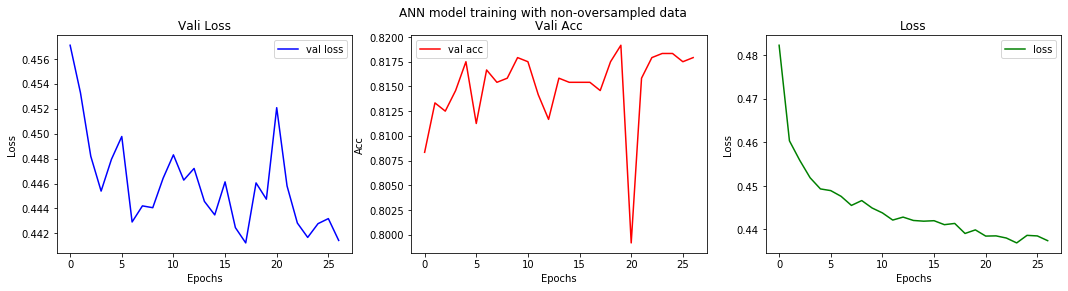

In [52]:
fig, axes = plt.subplots(1, 3, figsize=(18,4))
plt.suptitle("ANN model training with non-oversampled data")

axes[0].plot(history.history['val_loss'], color='b', label="val loss")
axes[0].set_title("Vali Loss")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Loss")
axes[0].legend()

axes[1].plot(history.history['val_accuracy'], color='r', label="val acc")
axes[1].set_title("Vali Acc")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Acc")
axes[1].legend()

axes[2].plot(history.history['loss'], color='green', label="loss")
axes[2].set_title("Loss")
axes[2].set_xlabel("Epochs")
axes[2].set_ylabel("Loss")
axes[2].legend()

plt.show()

In [54]:
# prediction
y_pred_ANN = ANN_model.predict(x_test_nos)
y_pred_ANN = np.argmax(y_pred_ANN, axis = 1)

# evaluation metrics
accuracy_ANN = accuracy_score(y_test, y_pred_ANN)
f1_ANN = f1_score(y_test, y_pred_ANN)
fp_ANN, fn_ANN = cal_FP_FN(y_test, y_pred_ANN)

print(f"Accuracy score for ANN (non-oversampled): {accuracy_ANN:.3f}")
print(f"f1 score for ANN (non-oversampled): {f1_ANN:.3f}")
print(f"False Positive rate for ANN (non-oversampled): {fp_ANN:.3f}")
print(f"False Negative rate for ANN (non-oversampled): {fn_ANN:.3f}")

# store the evaluation results
models_evals.loc['ANN (non-oversampled)', 'accuracy'] = round(accuracy_ANN, 3)
models_evals.loc['ANN (non-oversampled)', 'f1'] = round(f1_ANN, 3)
models_evals.loc['ANN (non-oversampled)', 'FP rate'] = round(fp_ANN, 3)
models_evals.loc['ANN (non-oversampled)', 'FN rate'] = round(fn_ANN, 3)

Accuracy score for ANN (non-oversampled): 0.833
f1 score for ANN (non-oversampled): 0.486
False Positive rate for ANN (non-oversampled): 0.044
False Negative rate for ANN (non-oversampled): 0.626


**Results for oversampled ANN**

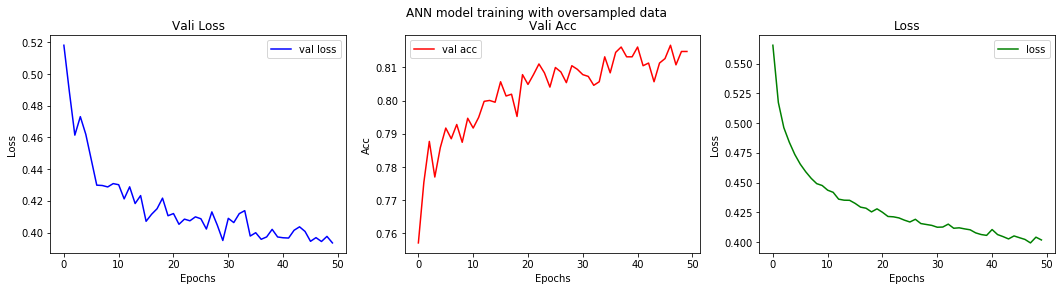

In [58]:
fig, axes = plt.subplots(1, 3, figsize=(18,4))
plt.suptitle("ANN model training with oversampled data")

axes[0].plot(history_os.history['val_loss'], color='b', label="val loss")
axes[0].set_title("Vali Loss")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Loss")
axes[0].legend()

axes[1].plot(history_os.history['val_accuracy'], color='r', label="val acc")
axes[1].set_title("Vali Acc")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Acc")
axes[1].legend()

axes[2].plot(history_os.history['loss'], color='green', label="loss")
axes[2].set_title("Loss")
axes[2].set_xlabel("Epochs")
axes[2].set_ylabel("Loss")
axes[2].legend()

plt.show()

In [60]:
# prediction
y_pred_ANN_os = ANN_model_os.predict(x_test_oversampled)
y_pred_ANN_os = np.argmax(y_pred_ANN_os, axis = 1)

# evaluation metrics
accuracy_ANN_os = accuracy_score(y_test, y_pred_ANN_os)
f1_ANN_os = f1_score(y_test, y_pred_ANN_os)
fp_ANN_os, fn_ANN_os = cal_FP_FN(y_test, y_pred_ANN_os)

print(f"Accuracy score for ANN (oversampled): {accuracy_ANN_os:.3f}")
print(f"f1 score for ANN (oversampled): {f1_ANN_os:.3f}")
print(f"False Positive rate for ANN (oversampled): {fp_ANN_os:.3f}")
print(f"False Negative rate for ANN (oversampled): {fn_ANN_os:.3f}")

# store the evaluation results
models_evals.loc['ANN (oversampled)', 'accuracy'] = round(accuracy_ANN_os, 3)
models_evals.loc['ANN (oversampled)', 'f1'] = round(f1_ANN_os, 3)
models_evals.loc['ANN (oversampled)', 'FP rate'] = round(fp_ANN_os, 3)
models_evals.loc['ANN (oversampled)', 'FN rate'] = round(fn_ANN_os, 3)

Accuracy score for ANN (oversampled): 0.803
f1 score for ANN (oversampled): 0.496
False Positive rate for ANN (oversampled): 0.105
False Negative rate for ANN (oversampled): 0.540


## **4.5 XGBoost**

### 4.5.1 Data Preparation

In [21]:
# split validation set (train:val = 3:1)
x_train_xgb, x_val_xgb, y_train_xgb, y_val_xgb = train_test_split(x_train_nos, y_train_nos,
                                                                  test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2
print('non-oversampled Training set:', len(y_train_xgb), 
      'non-oversampled Validation set:', len(y_val_xgb),
      'non-oversampled Training/Validation:', len(y_train_xgb)/len(y_val_xgb))

x_train_xgb_os, x_val_xgb_os, y_train_xgb_os, y_val_xgb_os = train_test_split(x_train_oversampled, y_train_oversampled,
                                                                  test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2
print('oversampled Training set:', len(y_train_xgb_os), 
      'oversampled Validation set:', len(y_val_xgb_os),
      'oversampled Training/Validation:', len(y_train_xgb_os)/len(y_val_xgb_os))

non-oversampled Training set: 18000 non-oversampled Validation set: 6000 non-oversampled Training/Validation: 3.0


In [22]:
# create DMatrix
DTrain = xgb.DMatrix(x_train_xgb, label=y_train_xgb)
DVal = xgb.DMatrix(x_val_xgb, label=y_val_xgb)
DTest = xgb.DMatrix(x_test_nos, label=y_test)

DTrain_os = xgb.DMatrix(x_train_xgb_os, label=y_train_xgb_os)
DVal_os = xgb.DMatrix(x_val_xgb_os, label=y_val_xgb_os)
DTest_os = xgb.DMatrix(x_test_oversampled, label=y_test)

### 4.5.2 Model Training

In [83]:
# Baseline model: hyperparameters with default values
params = {
    # parameters for tree booster with default values
    'max_depth': 6,
    'min_child_weight': 1,
    'eta': 0.1,
    'subsample': 1,
    'colsample_bytree': 1,
    'gamma': 0,
    'alpha': 0,
    'lambda': 1,
    # other parameters
    'scale_pos_weight': 1.0,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss' # default for classification task
}

In [98]:
# train XGBoost model with non-oversampled data
# update the recommended value for 'scale_pos_weight'
default_count = y_train_xgb.sum()
nondefault_count = len(y_train_xgb) - default_count
params['scale_pos_weight'] = nondefault_count / default_count

xgb_model = xgb.train(
    params,
    DTrain,
    num_boost_round=1000,
    evals=[(DVal, 'valid')],
    early_stopping_rounds=15
)

print("Lowest logloss for validation set: {} with {} rounds".format(xgb_model.best_score, xgb_model.best_iteration+1))

[0]	valid-logloss:0.669844
Will train until valid-logloss hasn't improved in 15 rounds.
[1]	valid-logloss:0.650483
[2]	valid-logloss:0.634518
[3]	valid-logloss:0.620781
[4]	valid-logloss:0.608685
[5]	valid-logloss:0.599175
[6]	valid-logloss:0.590974
[7]	valid-logloss:0.583536
[8]	valid-logloss:0.577131
[9]	valid-logloss:0.571821
[10]	valid-logloss:0.567311
[11]	valid-logloss:0.562864
[12]	valid-logloss:0.559105
[13]	valid-logloss:0.556019
[14]	valid-logloss:0.553253
[15]	valid-logloss:0.550885
[16]	valid-logloss:0.549073
[17]	valid-logloss:0.547191
[18]	valid-logloss:0.54556
[19]	valid-logloss:0.544277
[20]	valid-logloss:0.543225
[21]	valid-logloss:0.542243
[22]	valid-logloss:0.541405
[23]	valid-logloss:0.540348
[24]	valid-logloss:0.539743
[25]	valid-logloss:0.538965
[26]	valid-logloss:0.538026
[27]	valid-logloss:0.537479
[28]	valid-logloss:0.536872
[29]	valid-logloss:0.536319
[30]	valid-logloss:0.535632
[31]	valid-logloss:0.535224
[32]	valid-logloss:0.534742
[33]	valid-logloss:0.53421

[286]	valid-logloss:0.507451
[287]	valid-logloss:0.507355
[288]	valid-logloss:0.507198
[289]	valid-logloss:0.50723
[290]	valid-logloss:0.507296
[291]	valid-logloss:0.507185
[292]	valid-logloss:0.506983
[293]	valid-logloss:0.50695
[294]	valid-logloss:0.506801
[295]	valid-logloss:0.506866
[296]	valid-logloss:0.506819
[297]	valid-logloss:0.506901
[298]	valid-logloss:0.506925
[299]	valid-logloss:0.506767
[300]	valid-logloss:0.506703
[301]	valid-logloss:0.506558
[302]	valid-logloss:0.506544
[303]	valid-logloss:0.506504
[304]	valid-logloss:0.506565
[305]	valid-logloss:0.506523
[306]	valid-logloss:0.506316
[307]	valid-logloss:0.506309
[308]	valid-logloss:0.506106
[309]	valid-logloss:0.506138
[310]	valid-logloss:0.506143
[311]	valid-logloss:0.506123
[312]	valid-logloss:0.506035
[313]	valid-logloss:0.505963
[314]	valid-logloss:0.506088
[315]	valid-logloss:0.50585
[316]	valid-logloss:0.505745
[317]	valid-logloss:0.505869
[318]	valid-logloss:0.505864
[319]	valid-logloss:0.505783
[320]	valid-loglo

In [99]:
# train XGBoost model with oversampled data
# set 'scale_pos_weight' back to default value 1.0 (for balanced classes)
params['scale_pos_weight'] = 1.0

xgb_model_os = xgb.train(
    params,
    DTrain_os,
    num_boost_round=1000,
    evals=[(DVal_os, 'valid')],
    early_stopping_rounds=15
)

print("Lowest logloss for validation set: {} with {} rounds".format(xgb_model_os.best_score, xgb_model_os.best_iteration+1))

[0]	valid-logloss:0.652637
Will train until valid-logloss hasn't improved in 15 rounds.
[1]	valid-logloss:0.619907
[2]	valid-logloss:0.591381
[3]	valid-logloss:0.568794
[4]	valid-logloss:0.547443
[5]	valid-logloss:0.530068
[6]	valid-logloss:0.514501
[7]	valid-logloss:0.50216
[8]	valid-logloss:0.490533
[9]	valid-logloss:0.480245
[10]	valid-logloss:0.471725
[11]	valid-logloss:0.46393
[12]	valid-logloss:0.45764
[13]	valid-logloss:0.451468
[14]	valid-logloss:0.446138
[15]	valid-logloss:0.440447
[16]	valid-logloss:0.435393
[17]	valid-logloss:0.430626
[18]	valid-logloss:0.42625
[19]	valid-logloss:0.422367
[20]	valid-logloss:0.418094
[21]	valid-logloss:0.415475
[22]	valid-logloss:0.412671
[23]	valid-logloss:0.410021
[24]	valid-logloss:0.407742
[25]	valid-logloss:0.405644
[26]	valid-logloss:0.402759
[27]	valid-logloss:0.400654
[28]	valid-logloss:0.398867
[29]	valid-logloss:0.397122
[30]	valid-logloss:0.395493
[31]	valid-logloss:0.393128
[32]	valid-logloss:0.39211
[33]	valid-logloss:0.390895
[3

[286]	valid-logloss:0.343521
[287]	valid-logloss:0.343509
[288]	valid-logloss:0.343559
[289]	valid-logloss:0.343461
[290]	valid-logloss:0.343255
[291]	valid-logloss:0.343124
[292]	valid-logloss:0.343013
[293]	valid-logloss:0.342881
[294]	valid-logloss:0.342756
[295]	valid-logloss:0.342783
[296]	valid-logloss:0.342751
[297]	valid-logloss:0.342656
[298]	valid-logloss:0.342593
[299]	valid-logloss:0.342505
[300]	valid-logloss:0.342486
[301]	valid-logloss:0.342437
[302]	valid-logloss:0.342408
[303]	valid-logloss:0.34241
[304]	valid-logloss:0.342424
[305]	valid-logloss:0.342419
[306]	valid-logloss:0.342431
[307]	valid-logloss:0.342478
[308]	valid-logloss:0.342516
[309]	valid-logloss:0.342376
[310]	valid-logloss:0.342183
[311]	valid-logloss:0.342119
[312]	valid-logloss:0.342082
[313]	valid-logloss:0.342178
[314]	valid-logloss:0.342188
[315]	valid-logloss:0.342178
[316]	valid-logloss:0.342086
[317]	valid-logloss:0.341937
[318]	valid-logloss:0.341927
[319]	valid-logloss:0.34196
[320]	valid-logl

### 4.5.3 Results

**Results for non-oversampled XGBoost**

In [100]:
# prediction
y_pred_xgb = [int(round(value)) for value in xgb_model.predict(DTest)]

# evaluation metrics
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)
fp_xgb, fn_xgb = cal_FP_FN(y_test, y_pred_xgb)

print(f"Accuracy score for XGBoost (non-oversampled): {accuracy_xgb:.3f}")
print(f"f1 score for XGBoost (non-oversampled): {f1_xgb:.3f}")
print(f"False Positive rate for XGBoost (non-oversampled): {fp_xgb:.3f}")
print(f"False Negative rate for XGBoost (non-oversampled): {fn_xgb:.3f}")

# store the evaluation results
models_evals.loc['XGBoost (non-oversampled)', 'accuracy'] = round(accuracy_xgb, 3)
models_evals.loc['XGBoost (non-oversampled)', 'f1'] = round(f1_xgb, 3)
models_evals.loc['XGBoost (non-oversampled)', 'FP rate'] = round(fp_xgb, 3)
models_evals.loc['XGBoost (non-oversampled)', 'FN rate'] = round(fn_xgb, 3)

Accuracy score for XGBoost (non-oversampled): 0.792
f1 score for XGBoost (non-oversampled): 0.525
False Positive rate for XGBoost (non-oversampled): 0.142
False Negative rate for XGBoost (non-oversampled): 0.455


**Results for oversampled XGBoost**

In [101]:
# prediction
y_pred_xgb_os = [int(round(value)) for value in xgb_model_os.predict(DTest_os)]

# evaluation metrics
accuracy_xgb_os = accuracy_score(y_test, y_pred_xgb_os)
f1_xgb_os = f1_score(y_test, y_pred_xgb_os)
fp_xgb_os, fn_xgb_os = cal_FP_FN(y_test, y_pred_xgb_os)

print(f"Accuracy score for XGBoost (oversampled): {accuracy_xgb_os:.3f}")
print(f"f1 score for XGBoost (oversampled): {f1_xgb_os:.3f}")
print(f"False Positive rate for XGBoost (oversampled): {fp_xgb_os:.3f}")
print(f"False Negative rate for XGBoost (oversampled): {fn_xgb_os:.3f}")

# store the evaluation results
models_evals.loc['XGBoost (oversampled)', 'accuracy'] = round(accuracy_xgb_os, 3)
models_evals.loc['XGBoost (oversampled)', 'f1'] = round(f1_xgb_os, 3)
models_evals.loc['XGBoost (oversampled)', 'FP rate'] = round(fp_xgb_os, 3)
models_evals.loc['XGBoost (oversampled)', 'FN rate'] = round(fn_xgb_os, 3)

Accuracy score for XGBoost (oversampled): 0.798
f1 score for XGBoost (oversampled): 0.471
False Positive rate for XGBoost (oversampled): 0.102
False Negative rate for XGBoost (oversampled): 0.574


## 4.6 Prediction Performance Comparison
Evaluation metrics: Accuracy, f1 score, False Positive (FP) rate, False Negative (FN) rate.
<br>**Conclusion: choose `non-oversampled XGBoost` as the final methodology since it has highest f1 score.**

In [102]:
models_evals

,accuracy,f1,FP rate,FN rate
AdaBoost (oversampled),0.794,0.512,0.131,0.487
AdaBoost (non-oversampled),0.831,0.448,0.034,0.675
Random Forest (oversampled),0.817,0.464,0.065,0.625
Random Forest (non-oversampled),0.821,0.37,0.026,0.75
GBRT (oversampled),0.827,0.506,0.064,0.58
GBRT (non-oversampled),0.831,0.465,0.04,0.652
ANN (oversampled),0.803,0.496,0.105,0.54
ANN (non-oversampled),0.833,0.486,0.044,0.626
XGBoost (oversampled),0.798,0.471,0.102,0.574
XGBoost (non-oversampled),0.792,0.525,0.142,0.455


# **5. Model Training & Validation**

We chose non-oversampled XGBoost as our final methodology. This section contains the step-by-step model training and hyperparameter tuning for our final optimal XGBoost model.

**Data Preparation**

In [56]:
# add back features names
columns = transformed_train.columns
x_train_xgb = pd.DataFrame(x_train_xgb, columns=columns.values[:-1])
x_val_xgb = pd.DataFrame(x_val_xgb, columns=columns.values[:-1])
x_test_nos = pd.DataFrame(x_test_nos, columns=columns.values[:-1])

y_train_xgb = pd.DataFrame(y_train_xgb, columns=[columns.values[-1]])
y_val_xgb = pd.DataFrame(y_val_xgb, columns=[columns.values[-1]])
y_test = pd.DataFrame(y_test, columns=[columns.values[-1]])

# create DMatrix
DTrain = xgb.DMatrix(x_train_xgb, label=y_train_xgb)
DVal = xgb.DMatrix(x_val_xgb, label=y_val_xgb)
DTest = xgb.DMatrix(x_test_nos, label=y_test)

### 5.1 Set up XGBoost model

In [14]:
params = {
    # parameters for tree booster with default values (to be tuned)
    'max_depth': 6,
    'min_child_weight': 1,
    'eta': .3,
    'subsample': 1,
    'colsample_bytree': 1,
    'gamma': 0,
    'alpha': 0,
    'lambda': 1,
    # other parameters
    'scale_pos_weight': 1.0,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss' # default for classification task
}

In [15]:
# global variable
NUM_BOOST_ROUND = 1000

**Estimate the 'scale_pos_weight'** - an XGBoost build-in hyperparameter designed to tune the behavior of the algorithm for imbalanced classification problem

In [23]:
# update the recommended value for 'scale_pos_weight'
default_count = y_train_xgb.sum()
nondefault_count = len(y_train_xgb) - default_count
params['scale_pos_weight'] = nondefault_count / default_count

print('scale_pos_weight =', nondefault_count / default_count)

scale_pos_weight = 3.5180722891566263


**Some helper functions**

In [16]:
# gridsearch parameter set (for 2 parameters) using 5-fold cross validation with single evaluation metrix 'logloss'
def gridsearch_best_params(params_set, param1_name:str, param2_name:str, string_format, figwidth=10):
    # create a DataFrame to hold the results
    results = pd.DataFrame(columns=['params', 'test-logloss-mean', 'boost rounds'])
    
    for param1, param2 in params_set:
        print(string_format.format(param1, param2))
        # update parameters
        params[param1_name] = param1
        params[param2_name] = param2
        
        # run CV
        cv_results = xgb.cv(
            params,
            DTrain,
            num_boost_round=NUM_BOOST_ROUND, # set up a large iteration, will stop early
            seed=42,
            nfold=5,
            metrics={'logloss'}, # default choice for classification task
            early_stopping_rounds=10)
        
        # write down the results
        mean_logloss = cv_results['test-logloss-mean'].min()
        boost_rounds = cv_results['test-logloss-mean'].argmin()
        results = results.append({'params':"({},{})".format(param1, param2), 'test-logloss-mean':mean_logloss, 'boost rounds':boost_rounds},
                                ignore_index=True)
    
    # visualise the results
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(figwidth,8))
    results.plot(x="params", y=["test-logloss-mean"], ax=ax[0], color='green')
    results.plot(x="params", y=["boost rounds"], ax=ax[1], x_compat=True)

    plt.setp(ax[0].get_xticklabels(), visible=False)
    plt.xticks(results.index, results['params']) 
    fig.suptitle("Gridsearch CV for parameters tuning: {}, {}".format(param1_name, param2_name), fontsize=14)
    plt.show()
    
    print(results)

In [17]:
# gridsearch parameter set (for single parameter) using 5-fold cross validation with single evaluation metrix 'logloss'
def gridsearch_best_param(param_set, param_name:str, string_format, figwidth=10, convert_to_str=False, timed=False):
    # create a DataFrame to hold the results
    results = pd.DataFrame(columns=['param', 'test-logloss-mean', 'boost rounds'])
    
    for param in param_set:
        print(string_format.format(param))
        # update parameters
        params[param_name] = param
        
        if timed:
            start = time.time()
        # run CV
        cv_results = xgb.cv(
            params,
            DTrain,
            num_boost_round=NUM_BOOST_ROUND,
            seed=42,
            nfold=5,
            metrics={'logloss'}, # default choice for classification task
            early_stopping_rounds=10)
        
        if timed:
            end = time.time()
            print ("Time used:", end - start)
        
        # write down the results
        mean_logloss = cv_results['test-logloss-mean'].min()
        boost_rounds = cv_results['test-logloss-mean'].argmin()
        results = results.append({'param':param, 'test-logloss-mean':mean_logloss, 'boost rounds':boost_rounds},
                                ignore_index=True)
    
    # visualise the results
    if convert_to_str:
        results['param'] = results['param'].astype(str)
    
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(figwidth,8))
    results.plot(x="param", y=["test-logloss-mean"], ax=ax[0], color='green')
    results.plot(x="param", y=["boost rounds"], ax=ax[1], x_compat=True)

    plt.setp(ax[0].get_xticklabels(), visible=False)
    plt.xticks(results.index, results['param'])
    fig.suptitle("Gridsearch CV for parameter tuning: {}".format(param_name), fontsize=14)
    plt.show()
    
    print(results)

### 5.2 Hyperparmeters Tuning

#### 5.2.1 Step 1: Tune max_depth and min_child_weight

CV with max_depth=3, min_child_weight=1
CV with max_depth=3, min_child_weight=3
CV with max_depth=3, min_child_weight=5
CV with max_depth=5, min_child_weight=1
CV with max_depth=5, min_child_weight=3
CV with max_depth=5, min_child_weight=5
CV with max_depth=7, min_child_weight=1
CV with max_depth=7, min_child_weight=3
CV with max_depth=7, min_child_weight=5
CV with max_depth=9, min_child_weight=1
CV with max_depth=9, min_child_weight=3
CV with max_depth=9, min_child_weight=5


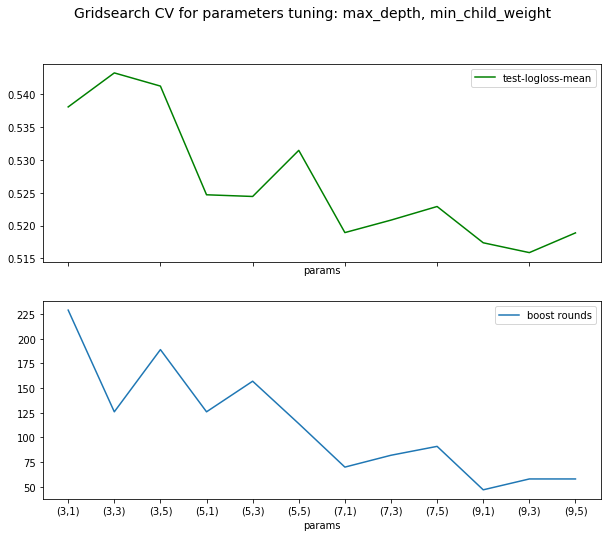

   params  test-logloss-mean boost rounds
0   (3,1)           0.538067          229
1   (3,3)           0.543249          126
2   (3,5)           0.541240          189
3   (5,1)           0.524682          126
4   (5,3)           0.524425          157
5   (5,5)           0.531449          114
6   (7,1)           0.518922           70
7   (7,3)           0.520824           82
8   (7,5)           0.522896           91
9   (9,1)           0.517370           47
10  (9,3)           0.515872           58
11  (9,5)           0.518877           58


In [24]:
# perform GridSearch on testing 12 combinations
param_test1 = [(max_depth, min_child_weight)
              for max_depth in range(3,10,2)
              for min_child_weight in range(1,6,2)]

gridsearch_best_params(param_test1, 'max_depth', 'min_child_weight', "CV with max_depth={}, min_child_weight={}")

Choose (9,3) which has the lowest test-logloss-mean and a low boost rounds. This can be considered as the optimal.
<br>
Need to check optimal value in step 1.

CV with max_depth=8, min_child_weight=2
CV with max_depth=8, min_child_weight=3
CV with max_depth=8, min_child_weight=4
CV with max_depth=9, min_child_weight=2
CV with max_depth=9, min_child_weight=3
CV with max_depth=9, min_child_weight=4
CV with max_depth=10, min_child_weight=2
CV with max_depth=10, min_child_weight=3
CV with max_depth=10, min_child_weight=4


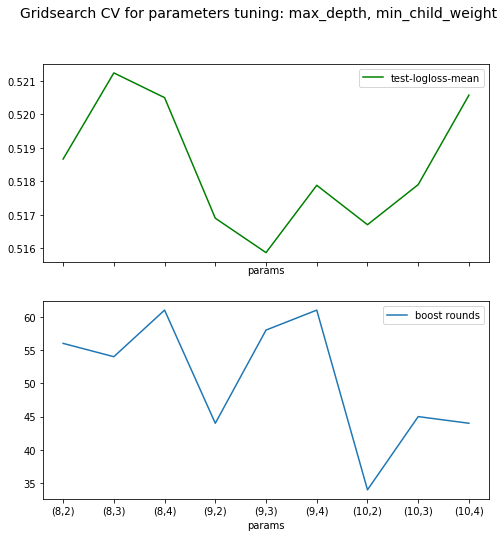

   params  test-logloss-mean boost rounds
0   (8,2)           0.518665           56
1   (8,3)           0.521234           54
2   (8,4)           0.520496           61
3   (9,2)           0.516898           44
4   (9,3)           0.515872           58
5   (9,4)           0.517881           61
6  (10,2)           0.516704           34
7  (10,3)           0.517901           45
8  (10,4)           0.520572           44


In [25]:
# test values in step 1, centred at (9,3)
param_test1b = [(max_depth, min_child_weight)
              for max_depth in [8,9,10]
              for min_child_weight in [2,3,4]]

gridsearch_best_params(param_test1b, 'max_depth', 'min_child_weight', "CV with max_depth={}, min_child_weight={}", 8)

(9,3) is still the optimal one.

In [26]:
# update optimal parameter values
params['max_depth'] = 9
params['min_child_weight'] = 3

#### 5.2.2 Step 2: Tune subsamples and colsample_bytree

CV with subsample=0.7, colsample_bytree=0.7
CV with subsample=0.7, colsample_bytree=0.8
CV with subsample=0.7, colsample_bytree=0.9
CV with subsample=0.7, colsample_bytree=1.0
CV with subsample=0.8, colsample_bytree=0.7
CV with subsample=0.8, colsample_bytree=0.8
CV with subsample=0.8, colsample_bytree=0.9
CV with subsample=0.8, colsample_bytree=1.0
CV with subsample=0.9, colsample_bytree=0.7
CV with subsample=0.9, colsample_bytree=0.8
CV with subsample=0.9, colsample_bytree=0.9
CV with subsample=0.9, colsample_bytree=1.0
CV with subsample=1.0, colsample_bytree=0.7
CV with subsample=1.0, colsample_bytree=0.8
CV with subsample=1.0, colsample_bytree=0.9
CV with subsample=1.0, colsample_bytree=1.0


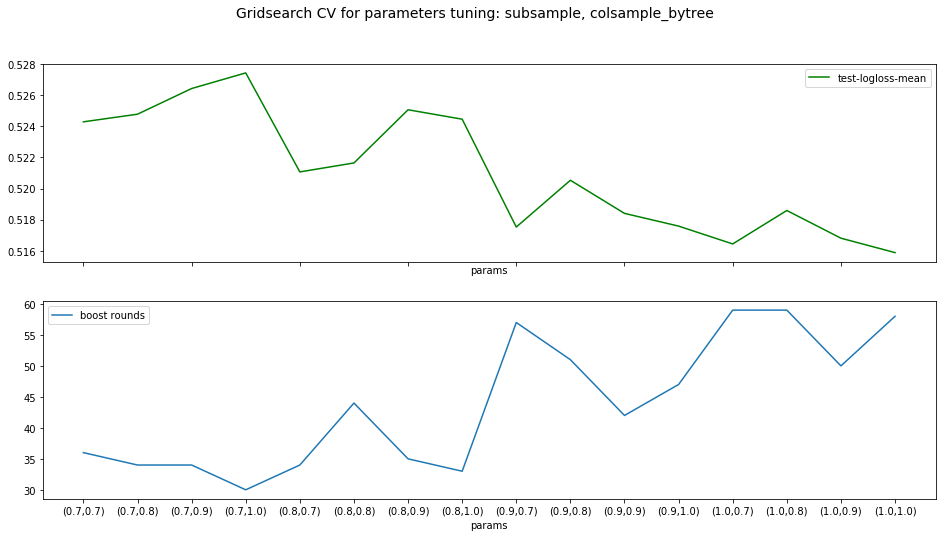

       params  test-logloss-mean boost rounds
0   (0.7,0.7)           0.524295           36
1   (0.7,0.8)           0.524786           34
2   (0.7,0.9)           0.526439           34
3   (0.7,1.0)           0.527445           30
4   (0.8,0.7)           0.521070           34
5   (0.8,0.8)           0.521647           44
6   (0.8,0.9)           0.525071           35
7   (0.8,1.0)           0.524464           33
8   (0.9,0.7)           0.517519           57
9   (0.9,0.8)           0.520531           51
10  (0.9,0.9)           0.518399           42
11  (0.9,1.0)           0.517579           47
12  (1.0,0.7)           0.516431           59
13  (1.0,0.8)           0.518584           59
14  (1.0,0.9)           0.516801           50
15  (1.0,1.0)           0.515872           58


In [27]:
# perform GridSearch on testing 16 combinations
param_test2 = [(subsample, colsample)
              for subsample in [i/10 for i in range(7,11)]
              for colsample in [i/10 for i in range(7,11)]]

gridsearch_best_params(param_test2, 'subsample', 'colsample_bytree', "CV with subsample={}, colsample_bytree={}", 16)

(1.0,0.7) has the lowest test-logloss-mean but a relatively high boost rounds. This can be considered as the optimal.
<br>
Need to check optimal value in step 0.05.

CV with subsample=0.95, colsample_bytree=0.65
CV with subsample=0.95, colsample_bytree=0.7
CV with subsample=0.95, colsample_bytree=0.75
CV with subsample=1.0, colsample_bytree=0.65
CV with subsample=1.0, colsample_bytree=0.7
CV with subsample=1.0, colsample_bytree=0.75


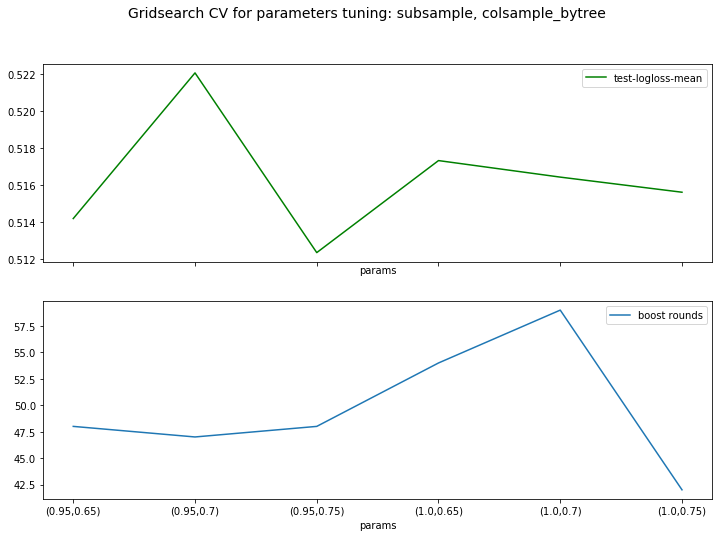

        params  test-logloss-mean boost rounds
0  (0.95,0.65)           0.514187           48
1   (0.95,0.7)           0.522073           47
2  (0.95,0.75)           0.512343           48
3   (1.0,0.65)           0.517326           54
4    (1.0,0.7)           0.516431           59
5   (1.0,0.75)           0.515612           42


In [28]:
# test values in step 0.05, centred at (1.0,0.7)
# note that 1.0 is the maximum value for 'subsample' and 'colsample_bytree'
param_test2b = [(subsample, colsample)
              for subsample in [i/100 for i in range(95,105,5)]
              for colsample in [i/100 for i in range(65,80,5)]]

gridsearch_best_params(param_test2b, 'subsample', 'colsample_bytree', "CV with subsample={}, colsample_bytree={}", 12)

(0.95,0.75) is the optimal one.

In [29]:
# update optimal parameter values
params['subsample'] = 0.95
params['colsample_bytree'] = 0.75

#### 5.2.3 Step 3:  Tune gamma

CV with gamma=0
CV with gamma=1
CV with gamma=2
CV with gamma=3
CV with gamma=4
CV with gamma=5
CV with gamma=6
CV with gamma=7
CV with gamma=8
CV with gamma=9
CV with gamma=10


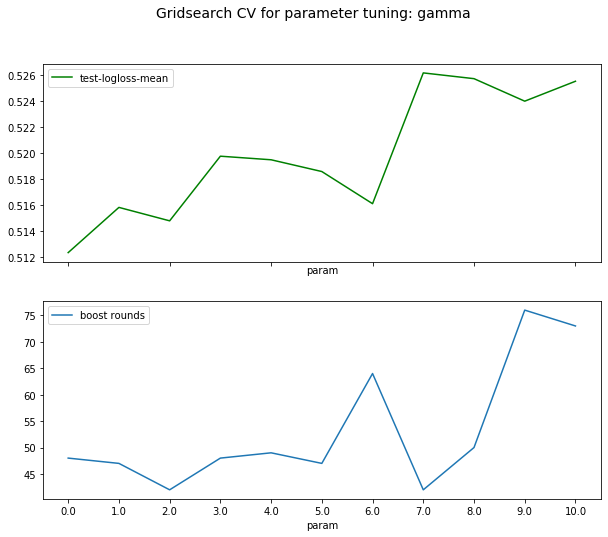

    param  test-logloss-mean  boost rounds
0     0.0           0.512343          48.0
1     1.0           0.515819          47.0
2     2.0           0.514786          42.0
3     3.0           0.519755          48.0
4     4.0           0.519480          49.0
5     5.0           0.518575          47.0
6     6.0           0.516104          64.0
7     7.0           0.526158          42.0
8     8.0           0.525715          50.0
9     9.0           0.523985          76.0
10   10.0           0.525516          73.0


In [30]:
# perform GridSearch on testing 11 values
param_test3 = [i for i in range(0,11)]

gridsearch_best_param(param_test3, 'gamma', "CV with gamma={}")

gamma = 0 has the lowest test-logloss-mean and a relatively low boost rounds. This can be considered as the optimal.
<br>
Need to check optimal value in step 0.1.

CV with gamma=0.0
CV with gamma=0.1
CV with gamma=0.2
CV with gamma=0.3
CV with gamma=0.4
CV with gamma=0.5
CV with gamma=0.6
CV with gamma=0.7
CV with gamma=0.8
CV with gamma=0.9
CV with gamma=1.0


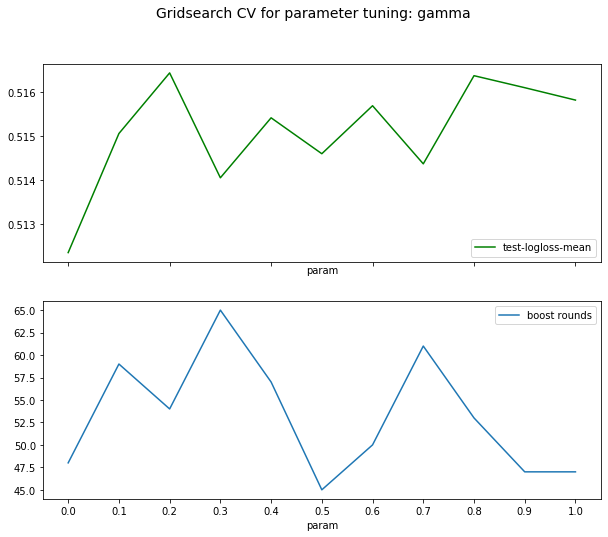

   param  test-logloss-mean  boost rounds
0    0.0           0.512343          48.0
1    0.1           0.515057          59.0
2    0.2           0.516438          54.0
3    0.3           0.514048          65.0
4    0.4           0.515415          57.0
5    0.5           0.514597          45.0
6    0.6           0.515690          50.0
7    0.7           0.514366          61.0
8    0.8           0.516375          53.0
9    0.9           0.516102          47.0
10   1.0           0.515819          47.0


In [31]:
# test values in step 0.1, centred at (0.0)
param_test3b = [i/10 for i in range(0,11)]

gridsearch_best_param(param_test3b, 'gamma', "CV with gamma={}", convert_to_str=True)

gamma = 0 is still the optimal one.

In [32]:
# update optimal parameter value
params['gamma'] = 0

#### 5.2.4 Step 4:  Tune regularisation parameters - alpha, lambda

CV with alpha=1e-05
CV with alpha=0.0001
CV with alpha=0.001
CV with alpha=0.01
CV with alpha=0.1
CV with alpha=1
CV with alpha=10
CV with alpha=50
CV with alpha=100


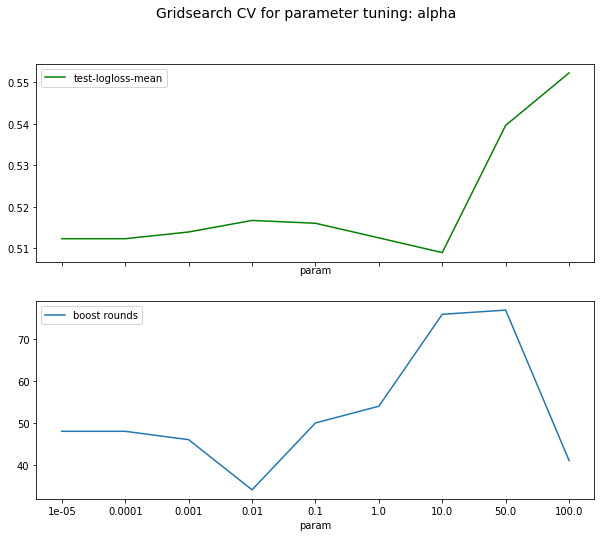

    param  test-logloss-mean  boost rounds
0   1e-05           0.512343          48.0
1  0.0001           0.512343          48.0
2   0.001           0.513959          46.0
3    0.01           0.516743          34.0
4     0.1           0.516064          50.0
5     1.0           0.512544          54.0
6    10.0           0.508994          76.0
7    50.0           0.539637          77.0
8   100.0           0.552273          41.0


In [33]:
# select 9 values from a broad range, perform GridSearch on testing these 9 values for 'alpha'
param_test4_alpha = [1e-5, 1e-4, 1e-3, 0.01, 0.1, 1, 10, 50, 100]

gridsearch_best_param(param_test4_alpha, 'alpha', "CV with alpha={}", convert_to_str=True)

alpha = 10.0 is a local minimal point. Need to check values around 10.

CV with alpha=1
CV with alpha=3
CV with alpha=5
CV with alpha=7
CV with alpha=10
CV with alpha=13
CV with alpha=15
CV with alpha=17
CV with alpha=20


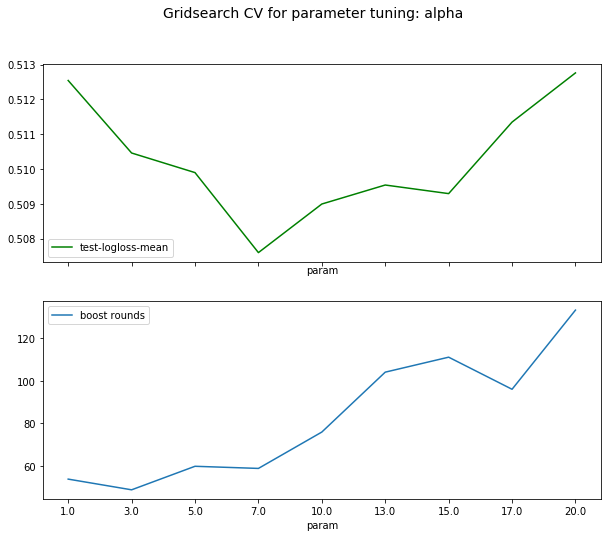

  param  test-logloss-mean  boost rounds
0   1.0           0.512544          54.0
1   3.0           0.510460          49.0
2   5.0           0.509897          60.0
3   7.0           0.507597          59.0
4  10.0           0.508994          76.0
5  13.0           0.509540         104.0
6  15.0           0.509293         111.0
7  17.0           0.511348          96.0
8  20.0           0.512762         133.0


In [34]:
# test values around 10
param_test4b_alpha = [1, 3, 5, 7, 10, 13, 15, 17, 20]

gridsearch_best_param(param_test4b_alpha, 'alpha', "CV with alpha={}", convert_to_str=True)

alpha = 7.0 has the lowest test-logloss-mean. Need to check values in step 0.5.

CV with alpha=5.5
CV with alpha=6.0
CV with alpha=6.5
CV with alpha=7.0
CV with alpha=7.5
CV with alpha=8.0
CV with alpha=8.5
CV with alpha=9.0


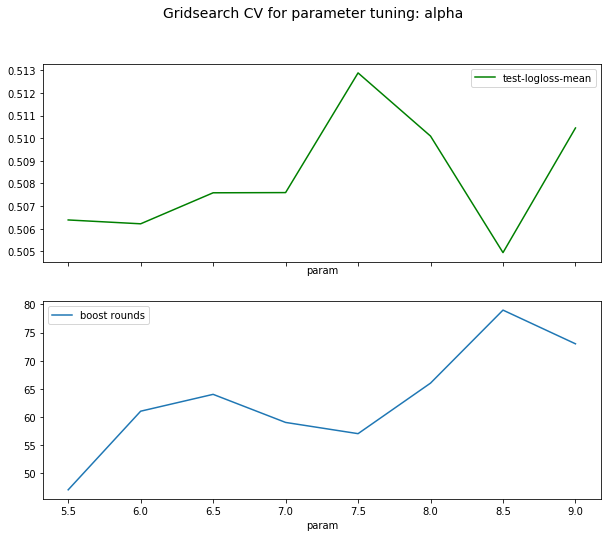

  param  test-logloss-mean  boost rounds
0   5.5           0.506389          47.0
1   6.0           0.506219          61.0
2   6.5           0.507588          64.0
3   7.0           0.507597          59.0
4   7.5           0.512883          57.0
5   8.0           0.510092          66.0
6   8.5           0.504947          79.0
7   9.0           0.510450          73.0


In [35]:
# test values in step 0.5, centred at 7.0
param_test4c_alpha = [i/10 for i in range(55,95,5)]

gridsearch_best_param(param_test4c_alpha, 'alpha', "CV with alpha={}", convert_to_str=True)

alpha = 8.5 is the optimal one.

In [36]:
# update optimal parameter value
params['alpha'] = 8.5

CV with lambda=1e-05
CV with lambda=0.0001
CV with lambda=0.001
CV with lambda=0.01
CV with lambda=0.1
CV with lambda=1
CV with lambda=10
CV with lambda=50
CV with lambda=100


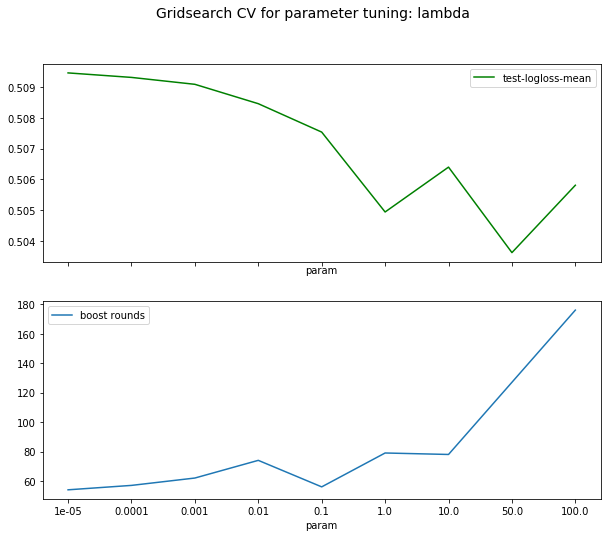

    param  test-logloss-mean  boost rounds
0   1e-05           0.509449          54.0
1  0.0001           0.509303          57.0
2   0.001           0.509080          62.0
3    0.01           0.508452          74.0
4     0.1           0.507533          56.0
5     1.0           0.504947          79.0
6    10.0           0.506399          78.0
7    50.0           0.503632         127.0
8   100.0           0.505813         176.0


In [37]:
# select 9 values from a broad range, perform GridSearch on testing 9 values for 'lambda'
param_test4_lambda = [1e-5, 1e-4, 1e-3, 0.01, 0.1, 1, 10, 50, 100]

gridsearch_best_param(param_test4_lambda, 'lambda', "CV with lambda={}", convert_to_str=True)

In general, the higher the lambda, the lower the test-logloss-mean. Take a closer look at values between 0.1 and 50 (the flucuation part). 

CV with lambda=0.1
CV with lambda=0.3
CV with lambda=0.6
CV with lambda=0.9
CV with lambda=1
CV with lambda=3
CV with lambda=6
CV with lambda=9
CV with lambda=10
CV with lambda=20
CV with lambda=30
CV with lambda=40
CV with lambda=50


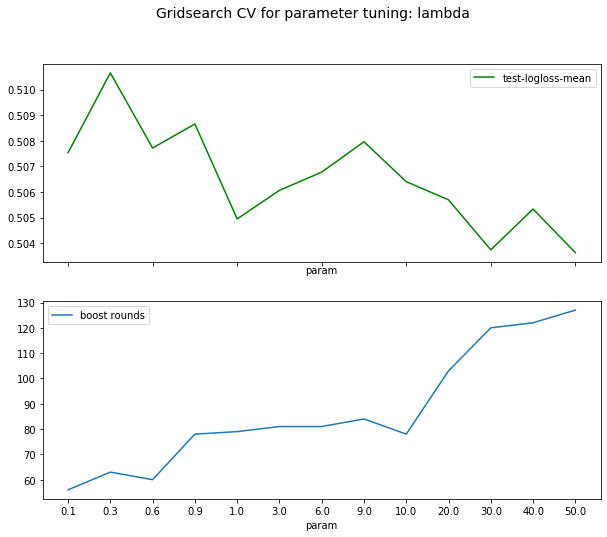

   param  test-logloss-mean  boost rounds
0    0.1           0.507533          56.0
1    0.3           0.510648          63.0
2    0.6           0.507714          60.0
3    0.9           0.508654          78.0
4    1.0           0.504947          79.0
5    3.0           0.506063          81.0
6    6.0           0.506774          81.0
7    9.0           0.507960          84.0
8   10.0           0.506399          78.0
9   20.0           0.505693         103.0
10  30.0           0.503741         120.0
11  40.0           0.505333         122.0
12  50.0           0.503632         127.0


In [38]:
# test values between 0.1 and 50
param_test4b_lambda = [0.1, 0.3, 0.6, 0.9, 1, 3, 6, 9, 10, 20, 30, 40, 50]

gridsearch_best_param(param_test4b_lambda, 'lambda', "CV with lambda={}", convert_to_str=True)

lambda = 30 has the lowest the test-logloss-mean. This is a relatively high lambda value, with the risk of underfitting the model. But let's consider it as the optimal at the moment.
<br>
Need to check values around 30 in a smaller step.

CV with lambda=25
CV with lambda=26
CV with lambda=27
CV with lambda=28
CV with lambda=29
CV with lambda=30
CV with lambda=31
CV with lambda=32
CV with lambda=33
CV with lambda=34
CV with lambda=35


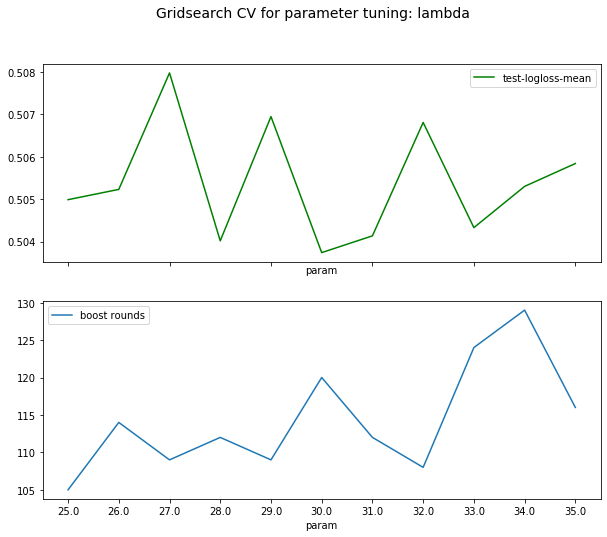

   param  test-logloss-mean  boost rounds
0   25.0           0.504989         105.0
1   26.0           0.505231         114.0
2   27.0           0.507977         109.0
3   28.0           0.504018         112.0
4   29.0           0.506947         109.0
5   30.0           0.503741         120.0
6   31.0           0.504136         112.0
7   32.0           0.506809         108.0
8   33.0           0.504329         124.0
9   34.0           0.505302         129.0
10  35.0           0.505841         116.0


In [39]:
# test values around 20 in step 1
param_test4c_lambda = [i for i in range(25,36,1)]

gridsearch_best_param(param_test4c_lambda, 'lambda', "CV with lambda={}", convert_to_str=True)

lambda = 30 is still the optimal one.

In [40]:
# update optimal parameter value
params['lambda'] = 30

#### 5.2.5 Step 5:  Reduce learning rate

CV with eta=1
Time used: 2.631953001022339
CV with eta=0.5
Time used: 6.1520349979400635
CV with eta=0.3
Time used: 9.676034927368164
CV with eta=0.1
Time used: 30.865551233291626
CV with eta=0.05
Time used: 62.829851150512695
CV with eta=0.01
Time used: 80.99657797813416
CV with eta=0.005
Time used: 80.92357778549194


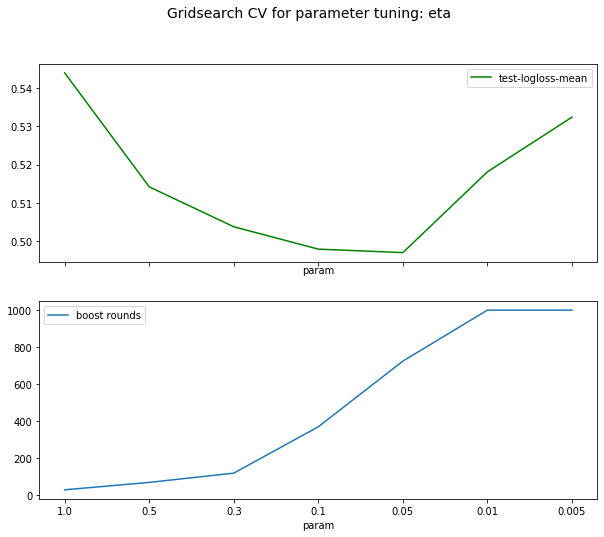

   param  test-logloss-mean  boost rounds
0    1.0           0.543979          30.0
1    0.5           0.514181          70.0
2    0.3           0.503741         120.0
3    0.1           0.497889         370.0
4   0.05           0.496983         724.0
5   0.01           0.518110         999.0
6  0.005           0.532402         999.0
CPU times: user 51min 4s, sys: 30.5 s, total: 51min 34s
Wall time: 4min 34s


In [41]:
# perform GridSearch on testing 7 values for eta
param_test5 = [1, .5, .3, .1, .05, .01, .005]

# timing
%time gridsearch_best_param(param_test5, 'eta', "CV with eta={}", convert_to_str=True, timed=True)

eta = 0.05 has lowest test-logloss-mean but a high boost rounds (724 rounds). However, it didn't take a long time to run (63 seconds). Hence, we can consider 0.05 as the optimal.

In [42]:
# update best parameter
params['eta'] = 0.05

# **6. Results**

In [43]:
# tuned hyperparameters values
params

# compared with default values:
# 'max_depth': 6,
# 'min_child_weight': 1,
# 'eta': 0.3,
# 'subsample': 1,
# 'colsample_bytree': 1,
# 'gamma': 0,
# 'alpha': 0,
# 'lambda': 1,

{'max_depth': 9,
 'min_child_weight': 3,
 'eta': 0.05,
 'subsample': 0.95,
 'colsample_bytree': 0.75,
 'gamma': 0,
 'alpha': 8.5,
 'lambda': 30,
 'scale_pos_weight': 3.5180722891566263,
 'objective': 'binary:logistic',
 'eval_metric': 'logloss'}

In [44]:
# feed in parameters to find optimal 'num_boost_round'
xgb_optimal = xgb.train(
    params,
    DTrain,
    num_boost_round=NUM_BOOST_ROUND,
    evals=[(DVal, 'valid')],
    early_stopping_rounds=10
)

print("Lowest logloss for validation set: {} with {} rounds".format(xgb_optimal.best_score, xgb_optimal.best_iteration+1))

[0]	valid-logloss:0.68174
Will train until valid-logloss hasn't improved in 10 rounds.
[1]	valid-logloss:0.671491
[2]	valid-logloss:0.661766
[3]	valid-logloss:0.652858
[4]	valid-logloss:0.644756
[5]	valid-logloss:0.639557
[6]	valid-logloss:0.63232
[7]	valid-logloss:0.627111
[8]	valid-logloss:0.622472
[9]	valid-logloss:0.616507
[10]	valid-logloss:0.611061
[11]	valid-logloss:0.607446
[12]	valid-logloss:0.60407
[13]	valid-logloss:0.600863
[14]	valid-logloss:0.596491
[15]	valid-logloss:0.592436
[16]	valid-logloss:0.588499
[17]	valid-logloss:0.585183
[18]	valid-logloss:0.582875
[19]	valid-logloss:0.579529
[20]	valid-logloss:0.576616
[21]	valid-logloss:0.574853
[22]	valid-logloss:0.573208
[23]	valid-logloss:0.570369
[24]	valid-logloss:0.568723
[25]	valid-logloss:0.566485
[26]	valid-logloss:0.564565
[27]	valid-logloss:0.562593
[28]	valid-logloss:0.560505
[29]	valid-logloss:0.558918
[30]	valid-logloss:0.557774
[31]	valid-logloss:0.556776
[32]	valid-logloss:0.555358
[33]	valid-logloss:0.553952


[285]	valid-logloss:0.503256
[286]	valid-logloss:0.502914
[287]	valid-logloss:0.502849
[288]	valid-logloss:0.502791
[289]	valid-logloss:0.502781
[290]	valid-logloss:0.502684
[291]	valid-logloss:0.502721
[292]	valid-logloss:0.502621
[293]	valid-logloss:0.50253
[294]	valid-logloss:0.502566
[295]	valid-logloss:0.502488
[296]	valid-logloss:0.502342
[297]	valid-logloss:0.502278
[298]	valid-logloss:0.502271
[299]	valid-logloss:0.502263
[300]	valid-logloss:0.502232
[301]	valid-logloss:0.502172
[302]	valid-logloss:0.502095
[303]	valid-logloss:0.502081
[304]	valid-logloss:0.50195
[305]	valid-logloss:0.50194
[306]	valid-logloss:0.501962
[307]	valid-logloss:0.501867
[308]	valid-logloss:0.501819
[309]	valid-logloss:0.501773
[310]	valid-logloss:0.501596
[311]	valid-logloss:0.501569
[312]	valid-logloss:0.501482
[313]	valid-logloss:0.501381
[314]	valid-logloss:0.501372
[315]	valid-logloss:0.50132
[316]	valid-logloss:0.501196
[317]	valid-logloss:0.50106
[318]	valid-logloss:0.501044
[319]	valid-logloss

In [59]:
# remove the early_stopping_rounds since we've got the exact optimal num_boost_round
NUM_BOOST_ROUND = xgb_optimal.best_iteration + 1

optimal_model = xgb.train(
    params,
    DTrain,
    num_boost_round=NUM_BOOST_ROUND,
    evals=[(DVal, 'valid')]
)

[0]	valid-logloss:0.68174
[1]	valid-logloss:0.671491
[2]	valid-logloss:0.661766
[3]	valid-logloss:0.652858
[4]	valid-logloss:0.644756
[5]	valid-logloss:0.639557
[6]	valid-logloss:0.63232
[7]	valid-logloss:0.627111
[8]	valid-logloss:0.622472
[9]	valid-logloss:0.616507
[10]	valid-logloss:0.611061
[11]	valid-logloss:0.607446
[12]	valid-logloss:0.60407
[13]	valid-logloss:0.600863
[14]	valid-logloss:0.596491
[15]	valid-logloss:0.592436
[16]	valid-logloss:0.588499
[17]	valid-logloss:0.585183
[18]	valid-logloss:0.582875
[19]	valid-logloss:0.579529
[20]	valid-logloss:0.576616
[21]	valid-logloss:0.574853
[22]	valid-logloss:0.573208
[23]	valid-logloss:0.570369
[24]	valid-logloss:0.568723
[25]	valid-logloss:0.566485
[26]	valid-logloss:0.564565
[27]	valid-logloss:0.562593
[28]	valid-logloss:0.560505
[29]	valid-logloss:0.558918
[30]	valid-logloss:0.557774
[31]	valid-logloss:0.556776
[32]	valid-logloss:0.555358
[33]	valid-logloss:0.553952
[34]	valid-logloss:0.553021
[35]	valid-logloss:0.551768
[36]	

[287]	valid-logloss:0.502849
[288]	valid-logloss:0.502791
[289]	valid-logloss:0.502781
[290]	valid-logloss:0.502684
[291]	valid-logloss:0.502721
[292]	valid-logloss:0.502621
[293]	valid-logloss:0.50253
[294]	valid-logloss:0.502566
[295]	valid-logloss:0.502488
[296]	valid-logloss:0.502342
[297]	valid-logloss:0.502278
[298]	valid-logloss:0.502271
[299]	valid-logloss:0.502263
[300]	valid-logloss:0.502232
[301]	valid-logloss:0.502172
[302]	valid-logloss:0.502095
[303]	valid-logloss:0.502081
[304]	valid-logloss:0.50195
[305]	valid-logloss:0.50194
[306]	valid-logloss:0.501962
[307]	valid-logloss:0.501867
[308]	valid-logloss:0.501819
[309]	valid-logloss:0.501773
[310]	valid-logloss:0.501596
[311]	valid-logloss:0.501569
[312]	valid-logloss:0.501482
[313]	valid-logloss:0.501381
[314]	valid-logloss:0.501372
[315]	valid-logloss:0.50132
[316]	valid-logloss:0.501196
[317]	valid-logloss:0.50106
[318]	valid-logloss:0.501044
[319]	valid-logloss:0.501061
[320]	valid-logloss:0.500979
[321]	valid-logloss

In [ ]:
# save model (optional)
# path = '' # change to your local directory
# optimal_model.save_model(path + 'CreditCardDefault_model_LogisticRegression_XGBoost.model')

# **7. Final Predictions on Test Set**

In this section, we first made predictions on the test set and used five statistics to evaluate the prediction performace. Then, we made use of the features importance scores provided by XGBoost trees to take feature selection, using the scikit-learn **SelectFromModel** class.

In [ ]:
# load model (optional)
# path = '' # change to your local directory
# loaded_model = xgb.Booster()
# loaded_model.load_model(path + 'CreditCardDefault_model_LogisticRegression_XGBoost.model')
# predictions_ = loaded_model.predict(DTest)

**Predictions on the test set**

In [60]:
predictions = [int(round(value)) for value in optimal_model.predict(DTest)]

### 7.1 Evaluation statistics
We measured five statistics for evaluating the performance for the predictions: accuracy score, f1 score, ROC AUC, False Positive, and False Negative (from confusion matrix).
<br>We also plotted the features importance using the XGBoost built-in function. The features importance are demonstrated in three types: by *weight*, by *gain* and by *cover*.

In [65]:
# evaluation metrics
accuracy_xgb_optimal = accuracy_score(y_test, predictions)
f1_xgb_optimal = f1_score(y_test, predictions)
roc_auc_xgb_optimal = roc_auc_score(y_test, predictions)

print(f"Accuracy score for the optimal model: {accuracy_xgb_optimal:.3f}")
print(f"f1 score for the optimal model: {f1_xgb_optimal:.3f}")
print(f"ROC AUC for the optimal model: {roc_auc_xgb_optimal:.3f}")

Accuracy score for the optimal model: 0.790
f1 score for the optimal model: 0.532
ROC AUC for the optimal model: 0.708


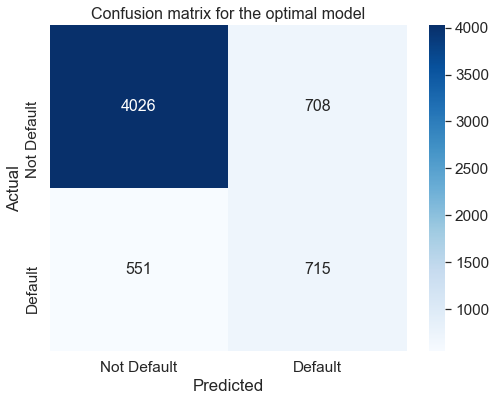

In [62]:
# evaluation - confusion matrix
optimal_cm = pd.DataFrame(confusion_matrix(y_test, predictions), 
                          columns=['Not Default', 'Default'], index = ['Not Default', 'Default'])
optimal_cm.index.name = 'Actual'
optimal_cm.columns.name = 'Predicted'
plt.figure(figsize = (8,6))
sns.set(font_scale=1.4) # label size
sns.heatmap(optimal_cm, cmap="Blues", annot=True, fmt='d', annot_kws={"size": 16}) # integer format, font size 16
plt.title('Confusion matrix for the optimal model', fontsize=16)
plt.show()

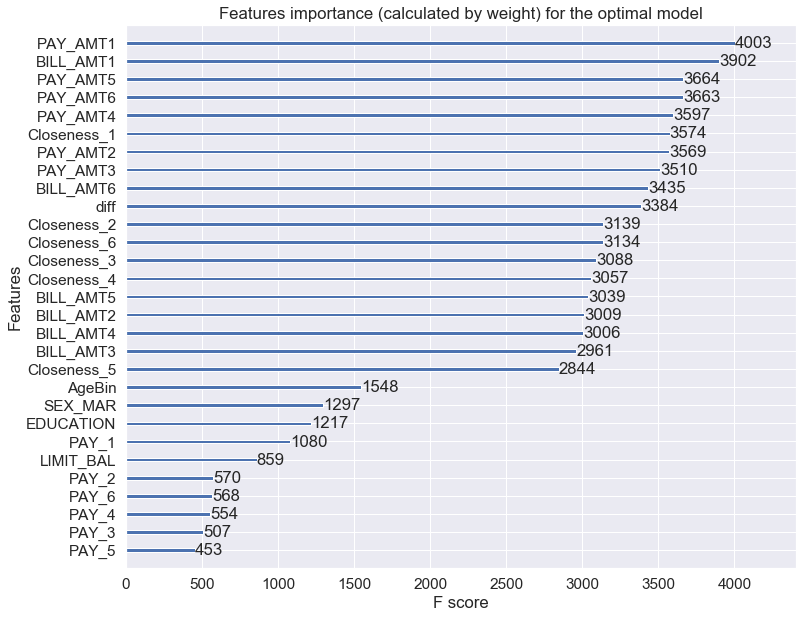

In [63]:
# features importance - by weight
fig, ax = plt.subplots(1,1,figsize=(12,10))
xgb.plot_importance(optimal_model, importance_type='weight', ax=ax)
plt.title('Features importance (calculated by weight) for the optimal model')
plt.show()

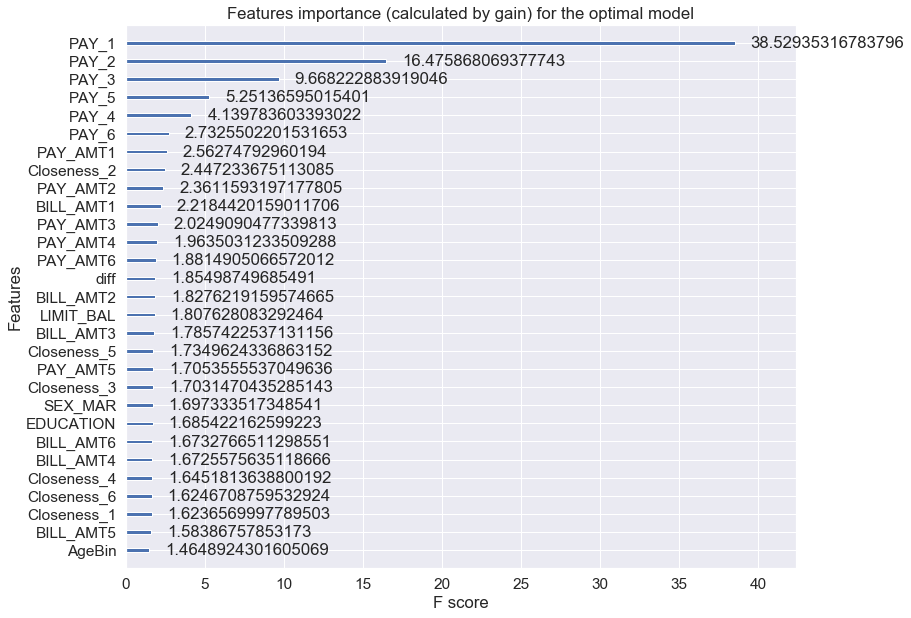

In [66]:
# features importance - by gain
fig, ax = plt.subplots(1,1,figsize=(12,10))
xgb.plot_importance(optimal_model, importance_type='gain', ax=ax)
plt.title('Features importance (calculated by gain) for the optimal model')
plt.show()

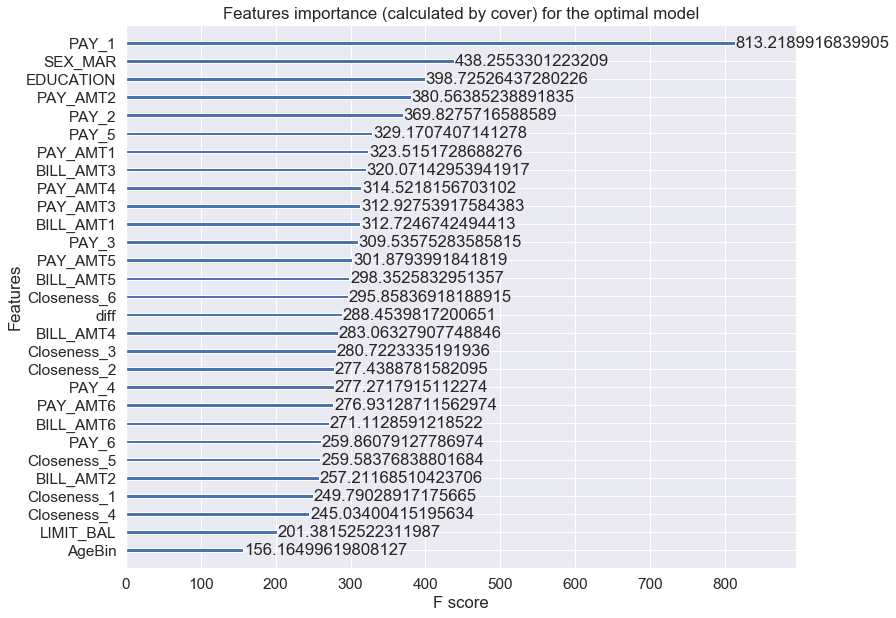

In [67]:
# features importance - by cover
fig, ax = plt.subplots(1,1,figsize=(12,10))
xgb.plot_importance(optimal_model, importance_type='cover', ax=ax)
plt.title('Features importance (calculated by cover) for the optimal model')
plt.show()

Summary of the statistics of the optimal model:
1. **Accuracy score**: 0.790
2. **f1 score**: 0.532
3. **ROC AUC**: 0.708
4. **False Positive**: 708 cases, **False Negative**: 551 cases.
5. The top 3 features appeared most in a tree are PAY_AMT1, BILL_AMT1, PAY_AMT5. The feature has the highest average gain and coverage of splits is PAY_1. 
<br>The 3 features appeared leaest in a tree are PAY_5, PAY_3, PAY_4. The feature has the lowest average gain and coverage of splits is AgeBin.

### 7.2 Feature Selection with XGBoost Feature Importance Scores

In [69]:
# set up an equivalent XGBClassifier model with tuned parameters - XGBoost's scikit-learn API
model = xgb.XGBClassifier(**params, n_estimators=NUM_BOOST_ROUND)
model.fit(x_train_xgb, y_train_xgb)

preds = model.predict(x_test_nos)

In [70]:
feature_importances = pd.DataFrame(model.feature_importances_, index=model.get_booster().feature_names, 
                                   columns=['Importance'])
feature_importances

,Importance
LIMIT_BAL,0.019052
EDUCATION,0.020063
SEX_MAR,0.018038
AgeBin,0.017619
diff,0.020496
PAY_1,0.254682
PAY_2,0.103374
PAY_3,0.068732
PAY_4,0.034247
PAY_5,0.039938


In [73]:
thresholds = np.sort(model.feature_importances_)
# create a DataFrame to hold the result
results = pd.DataFrame(columns=['Threshold', 'No. of features', 'Accuracy', 'F1', 'ROC AUC'])

for i in range(len(thresholds)):
    thresh = thresholds[i]
    # select features using threshold
    selection = SelectFromModel(estimator=model, threshold=thresh, prefit=True)
    select_Xtrain = selection.transform(x_train_xgb)
    # train model
    selection_model = xgb.XGBClassifier(**params, n_estimators=NUM_BOOST_ROUND)
    selection_model.fit(select_Xtrain, y_train_xgb)
    # predict
    select_Xtest = selection.transform(x_test_nos)
    predictions = selection_model.predict(select_Xtest)
    # eval model
    accuracy = accuracy_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)
    roc_auc = roc_auc_score(y_test, predictions)
    # save results
    results.loc[i, 'Threshold'] = np.round(thresh, 3)
    results.loc[i, 'No. of features'] = select_Xtrain.shape[1]
    results.loc[i, 'Accuracy'] = np.round(accuracy, 3)
    results.loc[i, 'F1'] = np.round(f1, 3)
    results.loc[i, 'ROC AUC'] = np.round(roc_auc, 3)

    print("Thresh=%.3f, n=%d" % (thresh, select_Xtrain.shape[1]))

Thresh=0.018, n=29
Thresh=0.018, n=28
Thresh=0.018, n=27
Thresh=0.019, n=26
Thresh=0.019, n=25
Thresh=0.019, n=24
Thresh=0.019, n=23
Thresh=0.019, n=22
Thresh=0.019, n=21
Thresh=0.020, n=20
Thresh=0.020, n=19
Thresh=0.020, n=18
Thresh=0.020, n=17
Thresh=0.020, n=16
Thresh=0.020, n=15
Thresh=0.020, n=14
Thresh=0.021, n=13
Thresh=0.021, n=12
Thresh=0.022, n=11
Thresh=0.022, n=10
Thresh=0.023, n=9
Thresh=0.024, n=8
Thresh=0.024, n=7
Thresh=0.034, n=6
Thresh=0.034, n=5
Thresh=0.040, n=4
Thresh=0.069, n=3
Thresh=0.103, n=2
Thresh=0.255, n=1


In [74]:
results.sort_values(['No. of features'], inplace=True)
results

,Threshold,No. of features,Accuracy,F1,ROC AUC
28,0.255,1,0.794,0.512,0.691
27,0.103,2,0.802,0.519,0.694
26,0.069,3,0.791,0.529,0.705
25,0.04,4,0.781,0.522,0.702
24,0.034,5,0.79,0.531,0.707
23,0.034,6,0.788,0.526,0.704
22,0.024,7,0.744,0.5,0.693
21,0.024,8,0.754,0.497,0.689
20,0.023,9,0.78,0.505,0.689
19,0.022,10,0.784,0.499,0.684


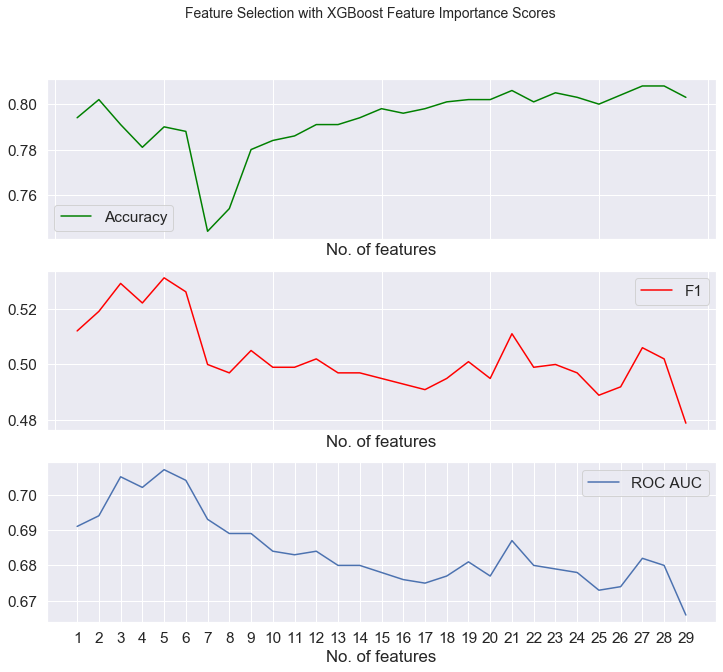

In [75]:
# visualise the results
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12,10))
results.plot('No. of features', y=['Accuracy'], ax=ax[0], color='green')
results.plot('No. of features', y=['F1'], ax=ax[1], color='red')
results.plot('No. of features', y=['ROC AUC'], ax=ax[2], x_compat=True)

plt.setp(ax[0].get_xticklabels(), visible=False)
plt.setp(ax[1].get_xticklabels(), visible=False)
plt.xticks(np.arange(min(results['No. of features']), max(results['No. of features']+1), 1))
fig.suptitle("Feature Selection with XGBoost Feature Importance Scores", fontsize=14)
plt.show()

Observations: Same tendency of change for these three evaluation scores.
<br>**Accuracy**: peaks at [2, 21:28]
<br>**F1**: peaks at [3, 5]
<br>**ROC AUC**: peaks at [3, 5]

In [76]:
# evaluation scores for the optimal model - regard as the base values for features selection
optimal_accuracy = results.iloc[-1]['Accuracy']
optimal_f1 = results.iloc[-1]['F1']
optimal_roc_auc = results.iloc[-1]['ROC AUC']

In [77]:
# thresholds with accuracy score higher than that of the optimal model
results.loc[(results['Accuracy'] > optimal_accuracy)]

,Threshold,No. of features,Accuracy,F1,ROC AUC
8,0.019,21,0.806,0.511,0.687
6,0.019,23,0.805,0.5,0.679
3,0.019,26,0.804,0.492,0.674
2,0.018,27,0.808,0.506,0.682
1,0.018,28,0.808,0.502,0.68


In [78]:
# thresholds with f1 score higher than that of the optimal model
results.loc[(results['F1'] > optimal_f1)]

,Threshold,No. of features,Accuracy,F1,ROC AUC
28,0.255,1,0.794,0.512,0.691
27,0.103,2,0.802,0.519,0.694
26,0.069,3,0.791,0.529,0.705
25,0.04,4,0.781,0.522,0.702
24,0.034,5,0.79,0.531,0.707
23,0.034,6,0.788,0.526,0.704
22,0.024,7,0.744,0.5,0.693
21,0.024,8,0.754,0.497,0.689
20,0.023,9,0.78,0.505,0.689
19,0.022,10,0.784,0.499,0.684


In [79]:
# thresholds with ROC AUC higher than that of the optimal model
results.loc[(results['ROC AUC'] > optimal_roc_auc)]

,Threshold,No. of features,Accuracy,F1,ROC AUC
28,0.255,1,0.794,0.512,0.691
27,0.103,2,0.802,0.519,0.694
26,0.069,3,0.791,0.529,0.705
25,0.04,4,0.781,0.522,0.702
24,0.034,5,0.79,0.531,0.707
23,0.034,6,0.788,0.526,0.704
22,0.024,7,0.744,0.5,0.693
21,0.024,8,0.754,0.497,0.689
20,0.023,9,0.78,0.505,0.689
19,0.022,10,0.784,0.499,0.684


Investigate no. of features = 2, 3, 5.
<br> n = 2: has the accuracy score, F1 and ROC AUC all higher than the optimal model.
<br> n = 3, 5: has the highest F1 and ROC AUC (much higher than the optimal model), but the accuracy socre is slightly lower than the optimal model.
<br> **Conclusion**: Either no. of features = **2, 3 or 5** is acceptable. n = 3 or 5 is slightly better than n = 2, with higher F1 and ROC AUC but a lower accuracy. We would decide to take a less complex model and accept a modest decrease in estimated accuracy from 80.8% (n = 2) down to 80.4% (n = 3) or 80.3% (n = 5).

In [80]:
# Get the selected features
def get_selected_features(no_of_features:int):
    df = feature_importances.sort_values(['Importance'], ascending=False)
    return df.iloc[:no_of_features].index.values

In [81]:
print('Selected features for n = 3:', get_selected_features(3))
print('Selected features for n = 5:', get_selected_features(5))

Selected features for n = 3: ['PAY_1' 'PAY_2' 'PAY_3']
Selected features for n = 5: ['PAY_1' 'PAY_2' 'PAY_3' 'PAY_5' 'PAY_4']


Therefore, We can see that **PAY_n are the most important features**.